# Back of envelope for QF measurements:

This notebook will calculate the rough rates/timing for the QF measurements.

Assumptions:

- The beam pulse rise/fall time is instantaneous.
- The proton doesn't lose any energy in the LiF foil.
- Every neutron source is a point source at the centre of the volume.
- The angle subtended by the NaI is its rear face.
- The angle subtended by the LS detectors is their front face.
- All detectors have circular cross-sections.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants, integrate
import pandas as pd
from pyne.endf import Evaluation
%matplotlib inline

In [2]:
def process_xsn(fname, hdrlines=7):
    this_xsec = pd.read_csv(fname, delim_whitespace=True, header=hdrlines)
    this_xsec.dropna(inplace=True)
    this_xsec.drop('Interpolation', axis=1, inplace=True)
    this_xsec = this_xsec.apply(pd.to_numeric, errors='coerce')
    this_xsec.ix[:,0] /= 1e6
    this_xsec.columns = ['Energy (MeV)', 'Cross-Section (b)']
    return this_xsec

In [3]:
def OutgoingEnergy(theta_cm, m_incident, m_target, E_incident):
    v_incident_sq = 2*E_incident/m_incident
    v_out_sq = v_incident_sq*(m_incident**2 + m_target**2 + 2*m_incident*m_target*np.cos(theta_cm))/\
                ((m_incident + m_target)**2)
    return v_out_sq*m_incident*0.5

def GetLabAngle(E_incident, m_incident, m_target, E_scattered):
    alpha = m_target/m_incident
    beta = np.sqrt(E_scattered/E_incident)
    return np.arccos(((1+alpha)*beta**2 + 1 - alpha)/(2*beta))

In [4]:
3.39-3.5

-0.10999999999999988

In [6]:
OutgoingEnergy(70, 1, 23, 3.5)

3.397507624473775

In [5]:
def calc_legendre(prod_dist_Al):
    """
    Takes a set of Legendre coeffs at a given energy and returns the polynomial.
    """
    coeffs = np.asarray([1.0] + prod_dist_Al)
    for i in range(len(coeffs)):
        coeffs[i] *= (2.*i + 1)/2
    return np.polynomial.legendre.Legendre(coeffs)

In [6]:
def NeutronSpeed_c(Eneutron_MeV):
    '''
    Return the (non-relativistic) speed of a neutron given its energy in MeV, in units of c.
    '''
    speed = (Eneutron_MeV*2/constants.physical_constants['neutron mass energy equivalent in MeV'][0])**0.5 
    if np.any(speed > 0.1):
        print("WARNING: Non-relativistic speed > 0.1c. You really should use the relativistic speed at this point!")
        print("Neutron of energy (MeV):\n{0}\nNon-relativistic speed (c):\n{1}".format(Eneutron_MeV, speed))
    return speed

In [6]:
NeutronSpeed_c(5)

Neutron of energy (MeV):
5
Non-relativistic speed (c):
0.10316597555360023


0.10316597555360023

In [10]:
NeutronSpeed_c(3.6)

0.08753923308201156

In [11]:
NeutronSpeed_c(3.5)

0.08631484784408895

In [7]:
d_scatter = 25+16
t_gamma = d_scatter/30
t_neut = 25/(0.0875*30) + 16/(0.0825*30)
d_direct = 28
t_gamma_direct = d_direct/30
t_neut_direct = d_direct/(0.0875*30)

diff_scatter = t_neut - t_gamma
diff_direct = t_neut_direct - t_gamma_direct
print(diff_scatter)
print(diff_direct)

14.621789321789322
9.733333333333333


In [7]:
%%capture
Na23 = Evaluation('/home/lbignell/gitrepos/Notebooks/Na23_neutelastic_ENDF_2.txt')
Na23.target
Na23.read()
Na_elastic = Na23.reactions[2] #MT = 2 --> elastic scattering

#Li7 = Evaluation('/home/lbignell/notebooks/Li7_ENDF_p.star.txt')
Li7 = Evaluation('/home/lbignell/gitrepos/Notebooks/Li7_toBe7_ENDF.txt')
Li7.read(skip_mt=[2])
Li7_pn = Li7.reactions[50] #MT = 50 --> (p,n)
Li7_pn_pdist = Li7_pn.product_distribution[0]

I127 = Evaluation('/home/lbignell/gitrepos/Notebooks/I127_ENDF_n.star.txt')
try:
    I127.read()
except:
    print("Error reading I-127: if this is unexpected, investigate!")
I_elastic = I127.reactions[2] #MT = 2 --> elastic scattering


In [8]:
H1 = Evaluation('/home/lbignell/gitrepos/Notebooks/H1_nel_ENDF.txt')
H1.target
H1.read()
H_elastic = H1.reactions[2]

Reading MF=1, MT=451 Descriptive Data
Reading MF=3, MT=2 (z,elastic)


/home/lbignell/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


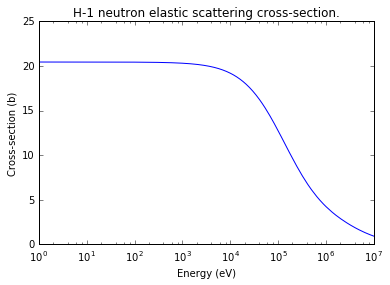

In [9]:
Energies = np.logspace(0,7,1000)
plt.plot(Energies, H_elastic.xs(Energies))
plt.xscale('log')
plt.xlabel('Energy (eV)')
plt.ylabel('Cross-section (b)')
plt.title('H-1 neutron elastic scattering cross-section.')

In [10]:
NeutMacroscopic_H = (0.97/28)*6.022*0.1*4*H_elastic.xs(5.2e6)
NeutMacroscopic_C = (0.97/28)*6.022*0.1*2*1.1

In [11]:
NeutMacroscopic = NeutMacroscopic_H + NeutMacroscopic_C

In [13]:
1-np.exp(-NeutMacroscopic*8.5)

0.77961233138439323

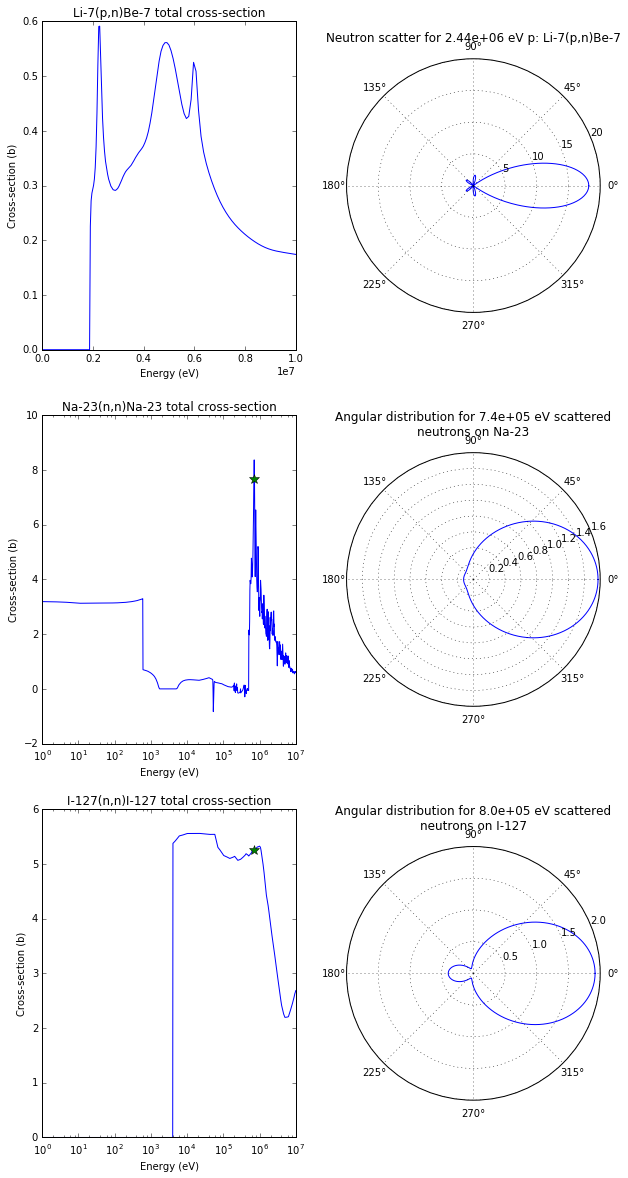

In [12]:
plt.figure(figsize=(10,20))
#make some plots of the xsn
#Li7(p,n)Be7
plt.subplot(321)
Energies = np.logspace(0, 7, 1000)
plt.plot(Energies, Li7_pn.xs(Energies))
#plt.plot(2.44e6, Li7_pn.xs(2.44e6), '*', markersize=10)
#plt.plot(4.55e6, Li7_pn.xs(4.55e6), '*', markersize=10)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross-section (b)')
plt.title('Li-7(p,n)Be-7 total cross-section')

plt.subplot(322, polar=True)
Leg_at_Ein = calc_legendre(Li7_pn_pdist['Al'][51])
p_Ein = Li7_pn_pdist['energy'][51]
theta_p = np.linspace(0., 2*constants.pi, 1000)
mu_p = np.cos(theta_p)
plt.plot(theta_p, Leg_at_Ein(mu_p))
plt.plot()
plt.title("Neutron scatter for {0:.2e} eV p: Li-7(p,n)Be-7".format(p_Ein))

plt.subplot(323)
plt.plot(Energies, Na_elastic.xs(Energies))
plt.plot(0.723e6, Na_elastic.xs(0.723e6), '*', markersize=10)
plt.xlabel('Energy (eV)')
plt.xscale('log')
plt.ylabel('Cross-section (b)')
plt.title('Na-23(n,n)Na-23 total cross-section')

plt.subplot(324, polar=True)
easd = Na_elastic.angular_distribution
pdf = easd.probability[40]
En = easd.energy[40]
theta = np.linspace(0., 2*constants.pi, 1000)
mu = np.cos(theta)
plt.plot(theta, pdf(mu))
plt.title("Angular distribution for {0:.1e} eV scattered\nneutrons on Na-23".format(En))

plt.subplot(325)
plt.plot(Energies, I_elastic.xs(Energies))
plt.plot(0.723e6, I_elastic.xs(0.723e6), '*', markersize=10)
plt.xlabel('Energy (eV)')
plt.xscale('log')
plt.ylabel('Cross-section (b)')
plt.title('I-127(n,n)I-127 total cross-section')

plt.subplot(326, polar=True)
easd = I_elastic.angular_distribution
pdf = easd.probability[10]
En = easd.energy[10]
theta = np.linspace(0., 2*constants.pi, 1000)
mu = np.cos(theta)
plt.plot(theta, pdf(mu))
plt.title("Angular distribution for {0:.1e} eV scattered\nneutrons on I-127".format(En))

plt.savefig('ENSDF_Plots.png', dpi=200)
plt.savefig('ENSDF_Plots.svg')
plt.savefig('ENSDF_Plots.pdf')

In [21]:
(1 - 1/(1+7))*5.2e6 #eV

4550000.0

10136.210820434411 mean protons per bunch
0.04330734067421906 mean neutrons per bunch produced by the target
53334.163391895396 neutrons per second produced by the target (period 1.875e-05 sec)
[ 215.60502685   68.05271586] neutrons/sec incident on the NaI
[ 28.27079498   8.92328164] Na scatters/sec in the NaI
[ 19.9089977   6.2839971] I scatters/sec in the NaI
Rates of Na-scattered neutrons on the LS detectors
Per Second:
[ 1.53410804  0.36649663  1.81544789  0.64220592  1.11948526  0.48769021
  1.52737393  0.2711119   1.47593003  0.63259267  1.01750947  1.04151722]
Per Hour:
[ 5522.78895385  1319.38785465  6535.61239942  2311.94132312  4030.14693015
  1755.68475087  5498.54615436   976.00284789  5313.34810682  2277.3336185
  3663.03408799  3749.46197879]
Rates (per second) of I-scattered neutrons on the LS detectors
Per Second:
[ 1.09378284  0.24671738  1.35750313  0.4641878   0.86623407  0.37301331
  1.1234431   0.17076787  1.12635712  0.44314408  0.79532189  0.7791174 ]
Per Hour:
[

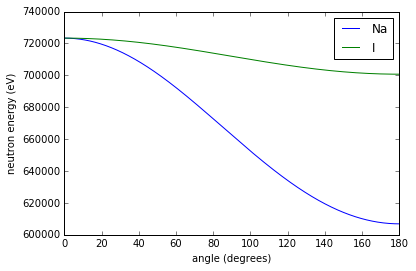

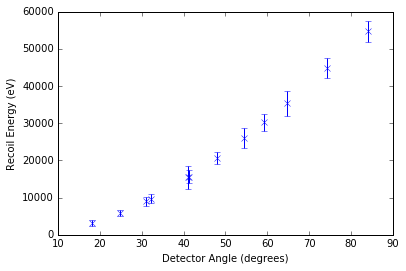

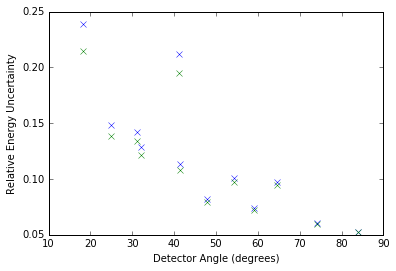

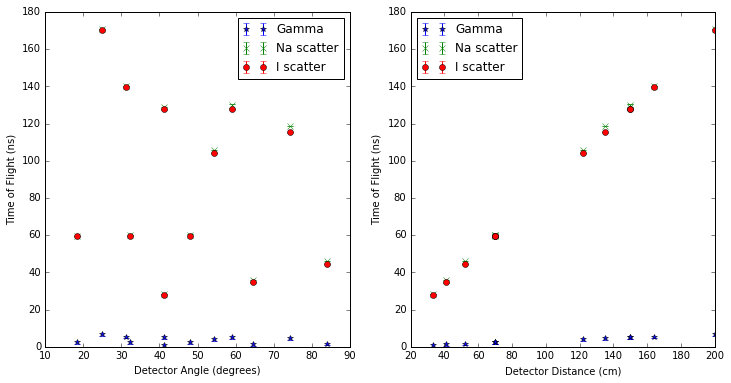

In [13]:
#Princeton values
#Beam properties:
Beam = {}
Beam['Current'] = 2e-9 #A, a value consistent with the Princeton group's claim of ~1e4 protons/bunch.
Beam['PulseWidth'] = 2e-9 #seconds
Beam['PulseFreq'] = 1/(812e-9) #Hz
Beam['ProtonsperBunch'] = Beam['Current']/(Beam['PulseFreq']* constants.elementary_charge)
print("{0} mean protons per bunch".format(Beam['ProtonsperBunch']))
Beam['SpotDiameter'] = 0.3 #cm
Beam['Energy'] = 2.44e6 #eV

##Target cross-sections
xsecs = {}
cm2perBarn = 1e-24
#I'm assuming ENDF uses lab frame energies.
Beam_xsec = Li7_pn.xs(Beam['Energy'])
Beam_xsec_cm2 = Beam_xsec*cm2perBarn
pdist_idx = (np.abs(Li7_pn_pdist['energy']-Beam['Energy'])).argmin()
pdist_actualEn = Li7_pn_pdist['energy'][pdist_idx] #eV
pdist_LegPoly = calc_legendre(Li7_pn_pdist['Al'][pdist_idx])

#Target properties:
Target = {}
Target['Ecm'] = (1/(1+7))*Beam['Energy']
Target['Vcm'] = np.sqrt(2*Target['Ecm']/8)
Target['Composition'] = 'LiF'
Target['ArealDensity'] = 0.00052 #g/cm^2
Target['MolarMass'] = 25.939 #g/mol
Target['Li7ArealDensity'] = 0.95*Target['ArealDensity']/Target['MolarMass'] #95% enriched, mol/cm^2 #*(0.95*7/(0.95*7 + 0.05*6 + 9))
Target['Li7ArealNumberDensity'] = (Target['Li7ArealDensity']) * constants.Avogadro #atoms/cm^2
Target['Density'] = 2.64 #g/cm^3
Target['Li7Density'] = 0.95*Target['Density']/Target['MolarMass'] #mol/cm^3 #*(0.95*7/(0.95*7 + 0.05*6 + 9)) #g/cm^3
Target['Li7NumberDensity'] = (Target['Li7Density']) * constants.Avogadro #atoms/cm^3
Target['nProductionQvalue'] = Li7_pn.Q_reaction #eV
Target['nEnergy_CM'] = 7/8*(Beam['Energy'] - Target['Ecm'] + Target['nProductionQvalue']) #eV
Target['nVelocity_CM'] = np.sqrt(2*Target['nEnergy_CM']/1)
Target['nVelocity_Lab'] = Target['nVelocity_CM'] + Target['Vcm']
Target['nEnergy'] = 0.5*1*(Target['nVelocity_Lab']**2)
Target['Thickness'] = Target['Li7ArealNumberDensity']/Target['Li7NumberDensity'] #cm

#Reaction Rate:
Target['NeutronsPerBunch'] = Beam['ProtonsperBunch']*Target['Li7ArealNumberDensity']*Beam_xsec_cm2
print("{0} mean neutrons per bunch produced by the target".format(Target['NeutronsPerBunch']))
Target['NeutronRate'] = Target['NeutronsPerBunch']*Beam['PulseFreq']
print("{0} neutrons per second produced by the target (period {1:.3e} sec)".format(Target['NeutronRate'], 1/Target['NeutronRate']))

##Detector properties:
#NaI(Tl):
NaI = {}
NaI['DecayTime'] = 250 #ns
NaI['Dimension'] = 2.5 #cm, assume cube
NaI['LightYield'] = 4e4 #ph/MeV
NaI['PhotoelectronYield'] = 18200#*(40/25) #+/- 100 PE/MeV, modified for UBA photocathode
NaI['Distance'] = np.array([50., 91.]) #cm, configurations 1 and 2.
NaI['SpreadAngle'] = np.arctan(NaI['Dimension']/(2*(NaI['Distance'] + NaI['Dimension'])))
NaI['Density'] = 3.67 #g/cm3
NaI['MolarMass'] = 149.89 #g/mol
NaI['AtomDensity'] = (NaI['Density']/NaI['MolarMass'])*constants.Avogadro # atoms/cm^3
NaI['NaDensity'] = 0.5*NaI['AtomDensity'] # Na/cm^3
NaI['IDensity'] = 0.5*NaI['AtomDensity'] # I/cm^3

#Optionally just use 1/R^2 and neglect the extent of the NaI crystal.
use_1onR2_pn = False
#Alternatively, assume all neutrons are forward. This overrides use_1onR2.
assume_allForward_pn = False
#Set both of the above to false to do a more proper analysis.
if use_1onR2_pn or assume_allForward_pn:
    if not assume_allForward_pn:
        NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']/(NaI['Distance']**2)
    else:
        NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']    
else:
    #The problem is symmetric, so I can just work from 0-pi and use half the angle subtended by the NaI
    #at the target (defined by 'SpreadAngle' above). 
    #I'm using the back of the NaI as an approximation, though it doesn't make much difference if the size
    #of the NaI << distance to target.
    #integrand = lambda x: 0.5*pdist_LegPoly(np.cos(x))**2##Why was this squared?
    integrand = lambda x: 0.5*pdist_LegPoly(np.cos(x))*np.sin(x)
    TotalIntegral = integrate.quad(integrand, 0, constants.pi)[0]
    NaIIntegral = np.array([integrate.quad(integrand, 0, ang)[0] for ang in NaI['SpreadAngle']])
    NaI['FractionIncident'] = NaIIntegral/TotalIntegral
    NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']*NaI['FractionIncident'] #This is the number of neutrons incident per bunch

NaI['NeutronRate'] = NaI['NeutronsPerBunch']*Beam['PulseFreq'] #This is the rate of neutrons incident.

print("{0} neutrons/sec incident on the NaI".format(NaI["NeutronRate"]))

#Need to include calculation of Na (and I) scatter cross-section.
Neut_xsec_Naelastic = Na_elastic.xs(Target['nEnergy'])
Neut_xsec_Naelastic_cm2 = Neut_xsec_Naelastic*cm2perBarn
Neut_xsec_Ielastic = I_elastic.xs(Target['nEnergy'])
Neut_xsec_Ielastic_cm2 = Neut_xsec_Ielastic*cm2perBarn

NaI['NaScatter_perBunch'] = NaI['NeutronsPerBunch']*(1-np.exp(-(NaI['NaDensity']*NaI['Dimension'])*Neut_xsec_Naelastic_cm2))#(NaI['NaDensity']*NaI['Dimension'])*Neut_xsec_Naelastic_cm2 #Scatters/Bunch
NaI['NaScatter_Rate'] = NaI['NaScatter_perBunch']*Beam['PulseFreq']
NaI['IScatter_perBunch'] = NaI['NeutronsPerBunch']*(1-np.exp(-(NaI['IDensity']*NaI['Dimension'])*Neut_xsec_Ielastic_cm2))#(NaI['IDensity']*NaI['Dimension'])*Neut_xsec_Ielastic_cm2 #Scatters/Bunch
NaI['IScatter_Rate'] = NaI['IScatter_perBunch']*Beam['PulseFreq']
NaI['nTOF'] = NaI['Distance']/(NeutronSpeed_c(Target['nEnergy']/1e6)*constants.c*1e-7) #ns

print("{0} Na scatters/sec in the NaI".format(NaI["NaScatter_Rate"]))
print("{0} I scatters/sec in the NaI".format(NaI["IScatter_Rate"]))

#Work out scattering angle-energy distributions:
xsecs['m_neutron'] = constants.neutron_mass/constants.m_u #u
xsecs['m_p'] = constants.proton_mass/constants.m_u #u
xsecs['m_Na'] = 22.98976928196 #u 
xsecs['m_I']= 126.904471853 #u
xsecs['theta_cm'] = np.linspace(0, np.pi-0.001, 1000)
ElasticNa = {}
ElasticNa['energies'] = OutgoingEnergy(xsecs['theta_cm'], xsecs['m_neutron'], xsecs['m_Na'], Target['nEnergy'])
ElasticNa['angles'] = GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], ElasticNa['energies'])
ElasticI = {}
ElasticI['energies'] = OutgoingEnergy(xsecs['theta_cm'], xsecs['m_neutron'], xsecs['m_I'], Target['nEnergy'])
ElasticI['angles'] = GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], ElasticI['energies'])
xsecs['ElasticNa'] = ElasticNa
xsecs['ElasticI'] = ElasticI
fig = plt.figure()
#plt.plot(xsecs['theta_cm']*360/(2*constants.pi), xsecs['ElasticNa']['energies'], label='Na_COM')
#plt.plot(xsecs['theta_cm']*360/(2*constants.pi), xsecs['ElasticI']['energies'], label='I_COM')
plt.plot(xsecs['ElasticNa']['angles']*360/(2*constants.pi), 
         xsecs['ElasticNa']['energies'], label='Na')
plt.plot(xsecs['ElasticI']['angles']*360/(2*constants.pi), 
         xsecs['ElasticI']['energies'], label='I')
plt.legend()
plt.xlabel('angle (degrees)')
plt.ylabel('neutron energy (eV)')

Nascatter_idx = (np.abs(Na_elastic.angular_distribution.energy-Target['nEnergy'])).argmin()
Nascatter_actualEn = Na_elastic.angular_distribution.energy[Nascatter_idx] #eV
Iscatter_idx = (np.abs(I_elastic.angular_distribution.energy-Target['nEnergy'])).argmin()
Iscatter_actualEn = I_elastic.angular_distribution.energy[Iscatter_idx] #eV

#LS detector:
LS = {}
LS['Composition'] = 'EJ-301'
LS['Diameter'] = np.array([12.7]*6 + [5.1]*6) #cm
LS['Length'] = np.array([12.7]*6 + [5.1]*6) #cm
LS['Distance'] = np.array([150,135,150,122,200,164,70,52,70,41,70,33])
LS['NumDetectors'] = int(len(LS['Distance'])/2)
LS['LightYield'] = 1e4 #ph/MeV
LS['PhotoelectronYield'] = -1 #Not mentioned in the paper
LS['MeanAngle'] = np.array([59.1,74.2,41.3,54.4,24.9,31.1,47.9,84.0,32.2,64.6,18.2,41.1])*constants.pi/180 #radians
LS['SpreadAngle'] = np.arctan(LS['Diameter']/(2*LS['Distance'])) #Half the angle subtended by the LS detectors at the NaI.
use_1onR2_es=False
if use_1onR2_es:
    if len(NaI['NeutronsPerBunch'])==1:
        LS['NeutronsPerBunchNa'] = 0.5*NaI['NeutronsPerBunch']/(LS['Distance']**2)
        LS['NeutronsPerBunchI'] = 0.5*NaI['NeutronsPerBunch']/(LS['Distance']**2)
    else:
        LS['NeutronsPerBunchNa'] = 0.5*np.array(list(NaI['NeutronsPerBunch'])*LS['NumDetectors'])/(LS['Distance']**2)
        LS['NeutronsPerBunchI'] = 0.5*np.array(list(NaI['NeutronsPerBunch'])*LS['NumDetectors'])/(LS['Distance']**2)
else:
    #The problem is symmetric, so I can just work from 0-pi and use half the angle subtended by the LS
    #at the target (defined by 'SpreadAngle' above).
    integrandNa = lambda x: 0.5*Na_elastic.angular_distribution.probability[Nascatter_idx](np.cos(x))*np.sin(x)#**2
    integrandI = lambda x: 0.5*I_elastic.angular_distribution.probability[Iscatter_idx](np.cos(x))*np.sin(x)#**2
    TotalIntegralNa = integrate.quad(integrandNa, 0, constants.pi)[0]
    TotalIntegralI = integrate.quad(integrandNa, 0, constants.pi)[0]
    LSIntegralNa = np.array([integrate.quad(integrandNa, LS['MeanAngle'][i]-ang, LS['MeanAngle'][i]+ang)[0] 
                             for i, ang in enumerate(LS['SpreadAngle'])])
    LSIntegralI = np.array([integrate.quad(integrandI, LS['MeanAngle'][i]-ang, LS['MeanAngle'][i]+ang)[0] 
                             for i, ang in enumerate(LS['SpreadAngle'])])
    LS['FractionIncidentNa'] = LSIntegralNa/TotalIntegralNa #of the ones that get scattered
    LS['FractionIncidentI'] = LSIntegralI/TotalIntegralI #of the ones that get scattered
    #Multiply the NaI scatter per bunch (into 4pi) by the fraction incident on the LS.
    LS['NeutronsPerBunchNa'] = np.array(list(NaI['NaScatter_perBunch'])*LS['NumDetectors'])*LS['FractionIncidentNa']
    LS['NeutronsPerBunchI'] = np.array(list(NaI['IScatter_perBunch'])*LS['NumDetectors'])*LS['FractionIncidentI']
    
LS['NeutronRateNa'] = LS['NeutronsPerBunchNa']*Beam['PulseFreq']
LS['NeutronRateI'] = LS['NeutronsPerBunchI']*Beam['PulseFreq']

print("Rates of Na-scattered neutrons on the LS detectors\n\
Per Second:\n{0}\nPer Hour:\n{1}".format(LS["NeutronRateNa"], LS["NeutronRateNa"]*3600))
print("Rates (per second) of I-scattered neutrons on the LS detectors\n\
Per Second:\n{0}\nPer Hour:\n{1}".format(LS["NeutronRateI"], LS["NeutronRateI"]*3600))

LS['nEnergy_Na'] = np.interp(LS['MeanAngle'], GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                                         xsecs['ElasticNa']['energies']),
                             xsecs['ElasticNa']['energies'])
LS['nEnergy_I'] = np.interp(LS['MeanAngle'], GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                                         xsecs['ElasticI']['energies']),
                             xsecs['ElasticI']['energies'])
LS['RecoilEnergy_Na'] = Target['nEnergy'] - LS['nEnergy_Na']
LS['RecoilEnergy_I'] = Target['nEnergy'] - LS['nEnergy_I']
LS['nEnergy_spread_Na_low'] = np.interp((LS['MeanAngle']+LS['SpreadAngle']), 
                                          GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                      xsecs['ElasticNa']['energies']), 
                                         xsecs['ElasticNa']['energies']) - LS['nEnergy_Na']
LS['nEnergy_spread_Na_high'] = np.interp((LS['MeanAngle']-LS['SpreadAngle']), 
                                         GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                      xsecs['ElasticNa']['energies']), 
                                         xsecs['ElasticNa']['energies']) - LS['nEnergy_Na']
LS['nEnergy_spread_I_low'] = np.interp((LS['MeanAngle']+LS['SpreadAngle']), 
                                          GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                      xsecs['ElasticI']['energies']), 
                                         xsecs['ElasticI']['energies']) - LS['nEnergy_I']
LS['nEnergy_spread_I_high'] = np.interp((LS['MeanAngle']-LS['SpreadAngle']), 
                                         GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                      xsecs['ElasticI']['energies']), 
                                         xsecs['ElasticI']['energies']) - LS['nEnergy_I']

LS['nTOF_Na'] = LS['Distance']/(NeutronSpeed_c(LS['nEnergy_Na']/1e6)*constants.c*1e-7) #ns
LS['nTOF_I'] = LS['Distance']/(NeutronSpeed_c(LS['nEnergy_I']/1e6)*constants.c*1e-7) #ns
LS['nTOF_spread_Na_low'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_Na'] + LS['nEnergy_spread_Na_low'])/1e6)
                                           *constants.c*1e-7) #ns
LS['nTOF_spread_Na_high'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_Na'] + LS['nEnergy_spread_Na_high'])/1e6)
                                            *constants.c*1e-7) #ns
LS['nTOF_spread_I_low'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_I'] + LS['nEnergy_spread_I_low'])/1e6)
                                          *constants.c*1e-7) #ns
LS['nTOF_spread_I_high'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_I'] + LS['nEnergy_spread_I_high'])/1e6)
                                           *constants.c*1e-7) #ns

LS['GammaTOF'] = LS['Distance']/(constants.c*1e-7)

LS['Hdensity'] = 5.43e22 #From EJ-309 datahsheet
LS_xsec_Helastic_Na = H_elastic.xs(LS['nEnergy_Na'])
LS_xsec_Helastic_Na_cm2 = LS_xsec_Helastic_Na*cm2perBarn
LS_xsec_Helastic_I = H_elastic.xs(LS['nEnergy_I'])
LS_xsec_Helastic_I_cm2 = LS_xsec_Helastic_I*cm2perBarn

LS['ElNaNeuts_perBunch'] = LS['NeutronsPerBunchNa']*(1-np.exp(-(LS['Hdensity']*LS['Length'])*LS_xsec_Helastic_Na_cm2)) #Scatters/Bunch
LS['ElNaNeuts_Rate'] = LS['ElNaNeuts_perBunch']*Beam['PulseFreq']
LS['ElINeuts_perBunch'] = LS['NeutronsPerBunchI']*(1-np.exp(-(LS['Hdensity']*LS['Length'])*LS_xsec_Helastic_I_cm2)) #Scatters/Bunch
LS['ElINeuts_Rate'] = LS['ElINeuts_perBunch']*Beam['PulseFreq']

fig = plt.figure()
plt.errorbar(LS['MeanAngle']*180/constants.pi, 
             LS['RecoilEnergy_Na'], 
             yerr=[np.abs(LS['nEnergy_spread_Na_low']), np.abs(LS['nEnergy_spread_Na_high'])],
             fmt='x')
#print("Relative Error: {0}".format((LS['nEnergy_spread_Na_low']/LS['RecoilEnergy_Na'], 
#                                    LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na'])))

plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Recoil Energy (eV)')

fig = plt.figure()
plt.plot(LS['MeanAngle']*180/constants.pi, np.abs(LS['nEnergy_spread_Na_low']/LS['RecoilEnergy_Na']), 'x')
plt.plot(LS['MeanAngle']*180/constants.pi, np.abs(LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na']), 'x')
plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Relative Energy Uncertainty')

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['GammaTOF'], fmt='*', yerr=[[1]*len(LS['GammaTOF']),[-1]*len(LS['GammaTOF'])],
             label='Gamma')
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['nTOF_Na'], yerr=[LS['nTOF_spread_Na_high']-LS['nTOF_Na'],
                                                                    LS['nTOF_spread_Na_low']-LS['nTOF_Na']], 
             fmt='x', label='Na scatter')
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['nTOF_I'], yerr=[LS['nTOF_spread_I_high']-LS['nTOF_I'], 
                                                                   LS['nTOF_spread_I_low']-LS['nTOF_I']], 
             fmt='o', label='I scatter')
plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Time of Flight (ns)')
plt.legend()

plt.subplot(122)
plt.errorbar(LS['Distance'], LS['GammaTOF'], fmt='*', yerr=[[1]*len(LS['GammaTOF']),[-1]*len(LS['GammaTOF'])],
             label='Gamma')
plt.errorbar(LS['Distance'], LS['nTOF_Na'], yerr=[LS['nTOF_spread_Na_high']-LS['nTOF_Na'],
                                                                    LS['nTOF_spread_Na_low']-LS['nTOF_Na']], 
             fmt='x', label='Na scatter')
plt.errorbar(LS['Distance'], LS['nTOF_I'], yerr=[LS['nTOF_spread_I_high']-LS['nTOF_I'], 
                                                                   LS['nTOF_spread_I_low']-LS['nTOF_I']], 
             fmt='o', label='I scatter')
plt.xlabel('Detector Distance (cm)')
plt.ylabel('Time of Flight (ns)')
plt.legend(loc='upper left')

In [22]:
Beam

{'Current': 2e-09,
 'Energy': 2440000.0,
 'ProtonsperBunch': 10136.210820434411,
 'PulseFreq': 1231527.0935960591,
 'PulseWidth': 2e-09,
 'SpotDiameter': 0.3}

In [23]:
Target

{'ArealDensity': 0.00052,
 'Composition': 'LiF',
 'Density': 2.64,
 'Ecm': 305000.0,
 'Li7ArealDensity': 1.9044681753344383e-05,
 'Li7ArealNumberDensity': 1.1468975609537761e+19,
 'Li7Density': 0.09668838428620996,
 'Li7NumberDensity': 5.822710694073018e+22,
 'MolarMass': 25.939,
 'NeutronRate': 53334.163391895396,
 'NeutronsPerBunch': 0.043307340674219062,
 'Thickness': 0.00019696969696969693,
 'Vcm': 276.13402542968151,
 'nEnergy': 723373.76623951504,
 'nEnergy_CM': 429362.5,
 'nProductionQvalue': -1644300.0,
 'nVelocity_CM': 926.67416064116082,
 'nVelocity_Lab': 1202.8081860708423}

In [24]:
NaI

{'AtomDensity': 1.4744984285269199e+22,
 'DecayTime': 250,
 'Density': 3.67,
 'Dimension': 2.5,
 'Distance': array([ 50.,  91.]),
 'FractionIncident': array([ 0.00404253,  0.00127597]),
 'IDensity': 7.372492142634599e+21,
 'IScatter_Rate': array([ 19.9089977,   6.2839971]),
 'IScatter_perBunch': array([  1.61661061e-05,   5.10260565e-06]),
 'LightYield': 40000.0,
 'MolarMass': 149.89,
 'NaDensity': 7.372492142634599e+21,
 'NaScatter_Rate': array([ 28.27079498,   8.92328164]),
 'NaScatter_perBunch': array([  2.29558855e-05,   7.24570469e-06]),
 'NeutronRate': array([ 215.60502685,   68.05271586]),
 'NeutronsPerBunch': array([  1.75071282e-04,   5.52588053e-05]),
 'PhotoelectronYield': 18200,
 'SpreadAngle': array([ 0.02380503,  0.01336819]),
 'nTOF': array([ 42.50269191,  77.35489927])}

(0, 150)

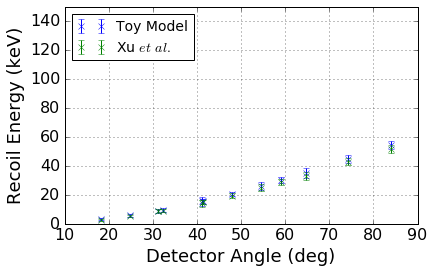

In [25]:
XuResults_recoil = np.array([29.0, 43.0, 15.0, 24.9, 5.7, 8.8, 19.4, 51.8, 9.1, 33.3, 2.9, 14.3])
XuResults_Urecoil = np.array([1.9, 2.2, 1.4, 2.4, 0.7, 1.2, 1.6, 2.6, 1.2, 2.8, 0.7, 2.4])
Xu_MeanAngle = np.array([59.1,74.2,41.3,54.4,24.9,31.1,47.9,84.0,32.2,64.6,18.2,41.1])
fig = plt.figure()
plt.errorbar(LS['MeanAngle']*180/constants.pi, 
             LS['RecoilEnergy_Na']/1e3, 
             yerr=[np.abs(LS['nEnergy_spread_Na_low'])/1e3, np.abs(LS['nEnergy_spread_Na_high'])/1e3],
             fmt='x')
plt.errorbar(Xu_MeanAngle, XuResults_recoil, yerr=XuResults_Urecoil, fmt='x')
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.xlabel('Detector Angle (deg)', fontsize=18)
plt.ylabel('Recoil Energy (keV)', fontsize=18)
plt.legend(['Toy Model', 'Xu $et$ $al.$'], loc='upper left', fontsize=14)
plt.grid(linestyle=':')
plt.tight_layout()
#plt.savefig('CompareXu_recoils.pdf')
plt.ylim(0,150)

In [26]:
NaRates_Xu = LS['ElNaNeuts_Rate']

In [27]:
LS['ElNaNeuts_Rate']*3600

array([ 5365.79253288,  1283.38985828,  6342.42404912,  2245.43792611,
        3908.03735761,  1702.91795832,  4168.38803412,   748.77521852,
        4013.60459075,  1735.38676786,  2761.00804271,  2837.65762458])

In [30]:
LS['ElNaNeuts_Rate']*3600*23/((4000+1000)/2)

array([ 49.3652913 ,  11.8071867 ,  58.35030125,  20.65802892,
        35.95394369,  15.66684522,  38.34916991,   6.88873201,
        36.92516223,  15.96555826,  25.40127399,  26.10645015])

In [31]:
LS['RecoilEnergy_Na']

array([ 30240.00315554,  44771.34097617,  15620.98196255,  26053.35884796,
         5876.94774957,   9067.41662528,  20625.9592462 ,  54696.36207229,
         9698.7461872 ,  35370.68103905,   3168.79600991,  15478.1090201 ])

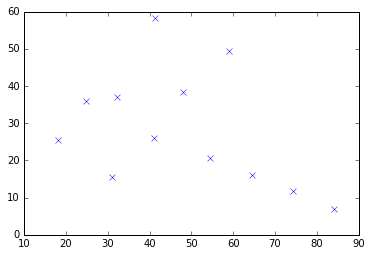

In [28]:
plt.plot(LS['MeanAngle']*180/np.pi, LS['ElNaNeuts_Rate']*3600*23/((4000+1000)/2), 'x')


In [38]:
LS

{'Composition': 'EJ-301',
 'Diameter': array([ 3.81,  3.81,  3.81,  3.81,  3.81,  3.81,  3.81,  3.81]),
 'Distance': array([150, 100,  75,  75,  50,  30,  30,  30]),
 'ElINeuts_Rate': array([ 0.00034006,  0.00076503,  0.0013598 ,  0.00135992,  0.00305863,
         0.0084816 ,  0.00848335,  0.00848481]),
 'ElINeuts_perBunch': array([  2.53910638e-10,   5.71218484e-10,   1.01531427e-09,
          1.01540735e-09,   2.28377764e-09,   6.33292466e-09,
          6.33423313e-09,   6.33532310e-09]),
 'ElNaNeuts_Rate': array([ 0.00048289,  0.0010864 ,  0.00193127,  0.00193222,  0.00434988,
         0.01207263,  0.01208482,  0.01209477]),
 'ElNaNeuts_perBunch': array([  3.60556892e-10,   8.11176545e-10,   1.44201606e-09,
          1.44272102e-09,   3.24790657e-09,   9.01422206e-09,
          9.02332967e-09,   9.03075654e-09]),
 'FractionIncidentI': array([  4.03176229e-05,   9.07009390e-05,   1.61211999e-04,
          1.61211999e-04,   3.62507883e-04,   1.00502414e-03,
          1.00502414e-03,  

In [34]:
LS['nTOF_I'] - LS['nTOF_Na']

array([-2.25779583, -3.05944033, -1.14711515, -1.5745568 , -0.56919309,
       -0.72268323, -0.71083841, -1.45657813, -0.3301718 , -0.72610511,
       -0.10709452, -0.25001689])

In [35]:
LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na']

array([ 0.07223315,  0.05990067,  0.1084826 ,  0.09765082,  0.13833808,
        0.13386312,  0.07955996,  0.05228148,  0.12176909,  0.09459929,
        0.21432829,  0.19475615])

In [21]:
LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na'] #2" PMTs --> 1.5" PMTs (only affects some)

array([ 0.07223315,  0.05990067,  0.1084826 ,  0.09765082,  0.13833808,
        0.13386312,  0.05991978,  0.0392362 ,  0.0920148 ,  0.07123259,
        0.1631305 ,  0.14786925])

In [27]:
LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na'] #double distance, same sizes

array([ 0.03634438,  0.03004619,  0.05491529,  0.04929525,  0.07040294,
        0.06804674,  0.04010971,  0.02617025,  0.06179679,  0.04766569,
        0.11033481,  0.09974776])

In [25]:
LS['nEnergy_spread_Na_high']

array([ 2402.73026447,  2949.97521114,  1864.03902435,  2798.50582625,
         894.29369004,  1335.15321495,  1805.07519084,  3145.52364644,
        1299.09005233,  3680.59402002,   747.06844591,  3315.85622338])

In [30]:
print(LS['ElNaNeuts_Rate']*3600)
print(sum(LS['ElNaNeuts_Rate']*3600))

[  484.7918132   1647.36191075  3415.66561203  3632.87625743  2749.38383152
  3175.91340381  2288.49462779  1308.01943812]
18702.5068947


In [24]:
print(LS['ElNaNeuts_Rate']*3600)
print(sum(LS['ElNaNeuts_Rate']*3600))

[  448.78050037  1525.22328727  3163.76430781  3369.38876369  2557.88181293
  2963.5833492   2141.81851332  1227.13658188]
17397.5771165


In [26]:
print(LS['ElNaNeuts_Rate']*3600)
print(sum(LS['ElNaNeuts_Rate']*3600))

[  338.39075714  1150.38190443  2388.14969763  2549.73973381  1947.22799052
  2269.41792763  1649.88487652   949.94642963]
13243.1393173


In [28]:
print(LS['ElNaNeuts_Rate']*3600)
print(sum(LS['ElNaNeuts_Rate']*3600))

[  215.37686375   732.34264535  1521.2195377   1627.17031938  1248.22192448
  1461.25340244  1067.16657964   616.77582151]
8489.52709425


In [36]:
sum(LS['NeutronRateNa'])*3600

42953.289006417457

array([ 0.43985079,  0.68609471,  0.90130556,  0.96891514])

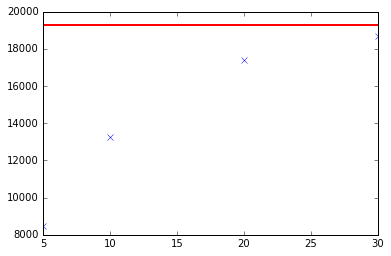

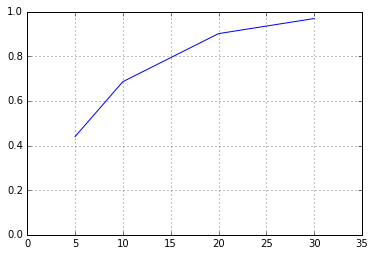

In [30]:
fig = plt.figure()
LSthickness = [5,10,20,30]#cm
TotCoincRate = [8490, 13243, 17397, 18702]#per hr
plt.plot(LSthickness, TotCoincRate, 'x')
plt.hlines(19302, 5,30, linewidth=2, color='r')
fig = plt.figure()
plt.plot(LSthickness, np.array(TotCoincRate)/19302)
plt.xlim(0, 35)
plt.ylim(0,1)
plt.grid()
np.array(TotCoincRate)/19302

In [29]:
NaI['NeutronsPerBunch']

array([ 0.00102441])

In [33]:
NaI['NaScatter_perBunch']/NaI['NeutronsPerBunch']

array([ 0.03061102])

In [38]:
NaI['NaScatter_Rate']

array([ 41.99768242])

In [43]:
LS['NeutronsPerBunchNa'] / NaI['NaScatter_perBunch']

array([  4.03176229e-05,   9.07009390e-05,   1.61211999e-04,
         1.61211999e-04,   3.62507883e-04,   1.00502414e-03,
         1.00502414e-03,   1.00502414e-03])

9320.647802577148 mean protons per bunch
0.05393223916303067 mean neutrons per bunch produced by the target
72230.72259468913 neutrons per second produced by the target (period 1.384e-05 sec)
[ 130.79352213] neutrons/sec incident on the NaI
[ 4.00372293] Na scatters/sec in the NaI
[ 6.29330516] I scatters/sec in the NaI
Rates of Na-scattered neutrons on the LS detectors
Per Second:
[ 0.00016142  0.00036314  0.00064545  0.00064545  0.00145138  0.00402384
  0.00402384  0.00402384]
Per Hour:
[  0.58111413   1.30730915   2.32361343   2.32361343   5.22497204
  14.48581748  14.48581748  14.48581748]
Rates (per second) of I-scattered neutrons on the LS detectors
Per Second:
[ 0.00025373  0.00057081  0.00101456  0.00101456  0.00228137  0.00632492
  0.00632492  0.00632492]
Per Hour:
[  0.91343198   2.05491128   3.65240269   3.65240269   8.21294182
  22.76972493  22.76972493  22.76972493]


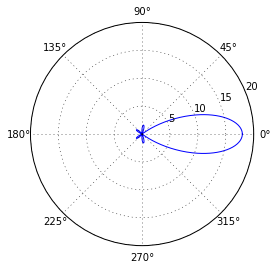

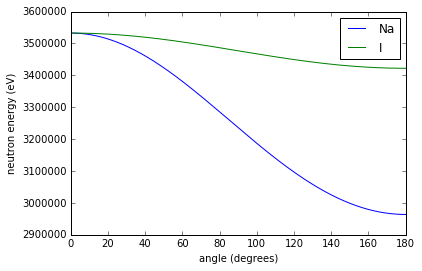

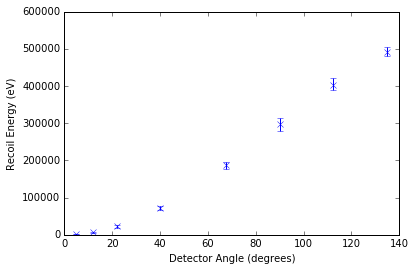

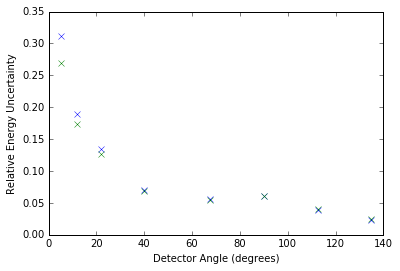

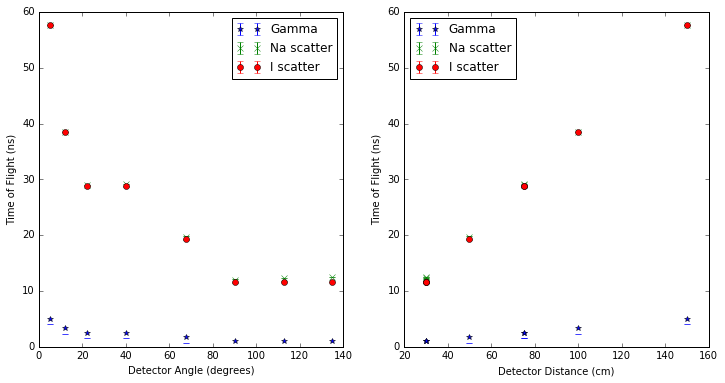

In [40]:
#plt.plot(LSthickness, TotCoincRate, 'x')
#ANU values
#Beam properties:
Beam = {}
Beam['Current'] = 2e-9 #A, a value consistent with the Princeton group's claim of ~1e4 protons/bunch.
Beam['PulseWidth'] = 2e-9 #seconds
Beam['PulseFreq'] = 1/(7*106.6666e-9)#1/(812e-9) #Hz
Beam['ProtonsperBunch'] = Beam['Current']/(Beam['PulseFreq']* constants.elementary_charge)
print("{0} mean protons per bunch".format(Beam['ProtonsperBunch']))
Beam['SpotDiameter'] = 0.3 #cm
Beam['Energy'] = 5.2e6 #eV

##Target cross-sections
xsecs = {}
cm2perBarn = 1e-24
#I'm assuming ENDF uses lab frame energies.
Beam_xsec = Li7_pn.xs(Beam['Energy'])
Beam_xsec_cm2 = Beam_xsec*cm2perBarn
pdist_idx = (np.abs(Li7_pn_pdist['energy']-Beam['Energy'])).argmin()
pdist_actualEn = Li7_pn_pdist['energy'][pdist_idx] #eV
pdist_LegPoly = calc_legendre(Li7_pn_pdist['Al'][pdist_idx])

plt.subplot(111, polar=True)
theta_p = np.linspace(0., 2*constants.pi, 1000)
mu_p = np.cos(theta_p)
plt.plot(theta_p, pdist_LegPoly(mu_p))


#Target properties:
Target = {}
Target['Ecm'] = (1/(1+7))*Beam['Energy']
Target['Vcm'] = np.sqrt(2*Target['Ecm']/8)
Target['Composition'] = 'LiF'
Target['ArealDensity'] = 0.5e-3 #g/cm^2, number from Jack's report
#Target['ArealDensity'] *= 10
Target['MolarMass'] = 25.939 #g/mol
Target['Li7ArealDensity'] = 0.95*Target['ArealDensity']/Target['MolarMass'] #95% enriched, mol/cm^2 #*(0.95*7/(0.95*7 + 0.05*6 + 9))
Target['Li7ArealNumberDensity'] = (Target['Li7ArealDensity']) * constants.Avogadro #atoms/cm^2
Target['Density'] = 2.64 #g/cm^3
Target['Li7Density'] = 0.95*Target['Density']/Target['MolarMass'] #mol/cm^3 #*(0.95*7/(0.95*7 + 0.05*6 + 9)) #g/cm^3
Target['Li7NumberDensity'] = (Target['Li7Density']) * constants.Avogadro #atoms/cm^3
Target['nProductionQvalue'] = Li7_pn.Q_reaction #eV
Target['nEnergy_CM'] = 7/8*(Beam['Energy'] - Target['Ecm'] + Target['nProductionQvalue']) #eV
Target['nVelocity_CM'] = np.sqrt(2*Target['nEnergy_CM']/1)
Target['nVelocity_Lab'] = Target['nVelocity_CM'] + Target['Vcm']
Target['nEnergy'] = 0.5*1*(Target['nVelocity_Lab']**2)
Target['Thickness'] = Target['Li7ArealNumberDensity']/Target['Li7NumberDensity'] #cm

#Reaction Rate:
Target['NeutronsPerBunch'] = Beam['ProtonsperBunch']*Target['Li7ArealNumberDensity']*Beam_xsec_cm2
print("{0} mean neutrons per bunch produced by the target".format(Target['NeutronsPerBunch']))
Target['NeutronRate'] = Target['NeutronsPerBunch']*Beam['PulseFreq']
print("{0} neutrons per second produced by the target (period {1:.3e} sec)".format(Target['NeutronRate'], 1/Target['NeutronRate']))

##Detector properties:
#NaI(Tl):
NaI = {}
NaI['DecayTime'] = 250 #ns
NaI['Dimension'] = 2.5 #cm, assume cube
NaI['LightYield'] = 4e4 #ph/MeV
NaI['PhotoelectronYield'] = 18200#*(40/25) #+/- 100 PE/MeV, modified for UBA photocathode
NaI['Distance'] = np.array([23.5]) #cm, configurations 1 and 2.
NaI['SpreadAngle'] = np.arctan(NaI['Dimension']/(2*(NaI['Distance'] + NaI['Dimension'])))
NaI['Density'] = 3.67 #g/cm3
NaI['MolarMass'] = 149.89 #g/mol
NaI['AtomDensity'] = (NaI['Density']/NaI['MolarMass'])*constants.Avogadro # atoms/cm^3
NaI['NaDensity'] = 0.5*NaI['AtomDensity'] # Na/cm^3
NaI['IDensity'] = 0.5*NaI['AtomDensity'] # I/cm^3

#Optionally just use 1/R^2 and neglect the extent of the NaI crystal.
use_1onR2_pn = True
#Alternatively, assume all neutrons are forward. This overrides use_1onR2.
assume_allForward_pn = False
#Set both of the above to false to do a more proper analysis.
if use_1onR2_pn or assume_allForward_pn:
    if not assume_allForward_pn:
        NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']/(NaI['Distance']**2)
    else:
        NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']    
else:
    #The problem is symmetric, so I can just work from 0-pi and use half the angle subtended by the NaI
    #at the target (defined by 'SpreadAngle' above). 
    #I'm using the back of the NaI as an approximation, though it doesn't make much difference if the size
    #of the NaI << distance to target.
    #integrand = lambda x: 0.5*pdist_LegPoly(np.cos(x))**2##Why was this squared?
    integrand = lambda x: 0.5*pdist_LegPoly(np.cos(x))*np.sin(x)
    TotalIntegral = integrate.quad(integrand, 0, constants.pi)[0]
    NaIIntegral = np.array([integrate.quad(integrand, 0, ang)[0] 
                            for ang in NaI['SpreadAngle']])
    NaI['FractionIncident'] = NaIIntegral/TotalIntegral
    NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']*\
        NaI['FractionIncident']#This is the number of neutrons incident per bunch

NaI['NeutronRate'] = NaI['NeutronsPerBunch']*Beam['PulseFreq'] #This is the rate of neutrons incident.

print("{0} neutrons/sec incident on the NaI".format(NaI["NeutronRate"]))

#Need to include calculation of Na (and I) scatter cross-section.
Neut_xsec_Naelastic = Na_elastic.xs(Target['nEnergy'])
Neut_xsec_Naelastic_cm2 = Neut_xsec_Naelastic*cm2perBarn
Neut_xsec_Ielastic = I_elastic.xs(Target['nEnergy'])
Neut_xsec_Ielastic_cm2 = Neut_xsec_Ielastic*cm2perBarn

NaI['NaScatter_perBunch'] = NaI['NeutronsPerBunch']*(1-np.exp(-(NaI['NaDensity']*NaI['Dimension'])*Neut_xsec_Naelastic_cm2))#(NaI['NaDensity']*NaI['Dimension'])*Neut_xsec_Naelastic_cm2 #Scatters/Bunch
NaI['NaScatter_Rate'] = NaI['NaScatter_perBunch']*Beam['PulseFreq']
NaI['IScatter_perBunch'] = NaI['NeutronsPerBunch']*(1-np.exp(-(NaI['IDensity']*NaI['Dimension'])*Neut_xsec_Ielastic_cm2))#(NaI['IDensity']*NaI['Dimension'])*Neut_xsec_Ielastic_cm2 #Scatters/Bunch
NaI['IScatter_Rate'] = NaI['IScatter_perBunch']*Beam['PulseFreq']
NaI['nTOF'] = NaI['Distance']/(NeutronSpeed_c(Target['nEnergy']/1e6)*constants.c*1e-7) #ns

print("{0} Na scatters/sec in the NaI".format(NaI["NaScatter_Rate"]))
print("{0} I scatters/sec in the NaI".format(NaI["IScatter_Rate"]))

#Work out scattering angle-energy distributions:
xsecs['m_neutron'] = constants.neutron_mass/constants.m_u #u
xsecs['m_p'] = constants.proton_mass/constants.m_u #u
xsecs['m_Na'] = 22.98976928196 #u 
xsecs['m_I']= 126.904471853 #u
xsecs['theta_cm'] = np.linspace(0, np.pi-0.001, 1000)
ElasticNa = {}
ElasticNa['energies'] = OutgoingEnergy(xsecs['theta_cm'], xsecs['m_neutron'], xsecs['m_Na'], Target['nEnergy'])
ElasticNa['angles'] = GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], ElasticNa['energies'])
ElasticI = {}
ElasticI['energies'] = OutgoingEnergy(xsecs['theta_cm'], xsecs['m_neutron'], xsecs['m_I'], Target['nEnergy'])
ElasticI['angles'] = GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], ElasticI['energies'])
xsecs['ElasticNa'] = ElasticNa
xsecs['ElasticI'] = ElasticI
fig = plt.figure()
#plt.plot(xsecs['theta_cm']*360/(2*constants.pi), xsecs['ElasticNa']['energies'], label='Na_COM')
#plt.plot(xsecs['theta_cm']*360/(2*constants.pi), xsecs['ElasticI']['energies'], label='I_COM')
plt.plot(xsecs['ElasticNa']['angles']*360/(2*constants.pi), 
         xsecs['ElasticNa']['energies'], label='Na')
plt.plot(xsecs['ElasticI']['angles']*360/(2*constants.pi), 
         xsecs['ElasticI']['energies'], label='I')
plt.legend()
plt.xlabel('angle (degrees)')
plt.ylabel('neutron energy (eV)')

Nascatter_idx = (np.abs(Na_elastic.angular_distribution.energy-Target['nEnergy'])).argmin()
Nascatter_actualEn = Na_elastic.angular_distribution.energy[Nascatter_idx] #eV
Iscatter_idx = (np.abs(I_elastic.angular_distribution.energy-Target['nEnergy'])).argmin()
Iscatter_actualEn = I_elastic.angular_distribution.energy[Iscatter_idx] #eV

#LS detector:
LS = {}
LS['Composition'] = 'EJ-301'
LS['Diameter'] = np.array([2.54*1.5]*8) #cm
LS['Length'] = np.array([15]*8) #cm
LS['Distance'] = np.array([150,100,75,75,50,30,30,30])
LS['NumDetectors'] = int(len(LS['Distance']))
LS['LightYield'] = 1e4 #ph/MeV
LS['PhotoelectronYield'] = -1 #Not mentioned in the paper
#LS['MeanAngle'] = np.array([24.9,31.1,41.3,47.9,54.4,59.1,74.2,84.0])*constants.pi/180 #radians
LS['MeanAngle'] = np.array([5.,12.,22, 40.,67.5,90,112.5,135.])*constants.pi/180 #radians
LS['SpreadAngle'] = np.arctan(LS['Diameter']/(2*LS['Distance'])) #Half the angle subtended by the LS detectors at the NaI.
use_1onR2_es=False
use_simpleSolidAngle = True
if use_1onR2_es:
    if len(NaI['NeutronsPerBunch'])==1:
        LS['NeutronsPerBunchNa'] = 0.5*NaI['NeutronsPerBunch']/(LS['Distance']**2)
        LS['NeutronsPerBunchI'] = 0.5*NaI['NeutronsPerBunch']/(LS['Distance']**2)
    else:
        LS['NeutronsPerBunchNa'] = 0.5*np.array(list(NaI['NeutronsPerBunch'])*LS['NumDetectors'])/(LS['Distance']**2)
        LS['NeutronsPerBunchI'] = 0.5*np.array(list(NaI['NeutronsPerBunch'])*LS['NumDetectors'])/(LS['Distance']**2)
elif use_simpleSolidAngle:
    LS['FractionIncidentNa'] = 0.5*(1-np.cos(LS['SpreadAngle']))
    LS['FractionIncidentI'] = 0.5*(1-np.cos(LS['SpreadAngle']))
    LS['NeutronsPerBunchNa'] = np.array(list(NaI['NaScatter_perBunch'])*
                                       LS['NumDetectors'])*\
                                LS['FractionIncidentNa']
    LS['NeutronsPerBunchI'] = np.array(list(NaI['IScatter_perBunch'])*
                                       LS['NumDetectors'])*\
                                LS['FractionIncidentI']
else:
    #The problem is symmetric, so I can just work from 0-pi and use half the angle subtended by the LS
    #at the target (defined by 'SpreadAngle' above).
    integrandNa = lambda x: 0.5*Na_elastic.angular_distribution.probability[Nascatter_idx](np.cos(x))*np.sin(x)#**2
    integrandI = lambda x: 0.5*I_elastic.angular_distribution.probability[Iscatter_idx](np.cos(x))*np.sin(x)#**2
    TotalIntegralNa = integrate.quad(integrandNa, 0, constants.pi)[0]
    TotalIntegralI = integrate.quad(integrandNa, 0, constants.pi)[0]
    LSIntegralNa = np.array([integrate.quad(integrandNa, LS['MeanAngle'][i]-ang, LS['MeanAngle'][i]+ang)[0] 
                             for i, ang in enumerate(LS['SpreadAngle'])])
    LSIntegralI = np.array([integrate.quad(integrandI, LS['MeanAngle'][i]-ang, LS['MeanAngle'][i]+ang)[0] 
                             for i, ang in enumerate(LS['SpreadAngle'])])
    LS['FractionIncidentNa'] = LSIntegralNa/TotalIntegralNa #of the ones that get scattered
    LS['FractionIncidentI'] = LSIntegralI/TotalIntegralI #of the ones that get scattered
    #Multiply the NaI scatter per bunch (into 4pi) by the fraction incident on the LS.
    LS['NeutronsPerBunchNa'] = np.array(list(NaI['NaScatter_perBunch'])*
                                        LS['NumDetectors'])*\
                                LS['FractionIncidentNa']
    LS['NeutronsPerBunchI'] = np.array(list(NaI['IScatter_perBunch'])*LS['NumDetectors'])*LS['FractionIncidentI']

LS['NeutronRateNa'] = LS['NeutronsPerBunchNa']*Beam['PulseFreq']
LS['NeutronRateI'] = LS['NeutronsPerBunchI']*Beam['PulseFreq']

print("Rates of Na-scattered neutrons on the LS detectors\n\
Per Second:\n{0}\nPer Hour:\n{1}".format(LS["NeutronRateNa"], LS["NeutronRateNa"]*3600))
print("Rates (per second) of I-scattered neutrons on the LS detectors\n\
Per Second:\n{0}\nPer Hour:\n{1}".format(LS["NeutronRateI"], LS["NeutronRateI"]*3600))

LS['nEnergy_Na'] = np.interp(LS['MeanAngle'], GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                                         xsecs['ElasticNa']['energies']),
                             xsecs['ElasticNa']['energies'])
LS['nEnergy_I'] = np.interp(LS['MeanAngle'], GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                                         xsecs['ElasticI']['energies']),
                             xsecs['ElasticI']['energies'])
LS['RecoilEnergy_Na'] = Target['nEnergy'] - LS['nEnergy_Na']
LS['RecoilEnergy_I'] = Target['nEnergy'] - LS['nEnergy_I']
LS['nEnergy_spread_Na_low'] = np.interp((LS['MeanAngle']+LS['SpreadAngle']), 
                                          GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                      xsecs['ElasticNa']['energies']), 
                                         xsecs['ElasticNa']['energies']) - LS['nEnergy_Na']
LS['nEnergy_spread_Na_high'] = np.interp((LS['MeanAngle']-LS['SpreadAngle']), 
                                         GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                      xsecs['ElasticNa']['energies']), 
                                         xsecs['ElasticNa']['energies']) - LS['nEnergy_Na']
LS['nEnergy_spread_I_low'] = np.interp((LS['MeanAngle']+LS['SpreadAngle']), 
                                          GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                      xsecs['ElasticI']['energies']), 
                                         xsecs['ElasticI']['energies']) - LS['nEnergy_I']
LS['nEnergy_spread_I_high'] = np.interp((LS['MeanAngle']-LS['SpreadAngle']), 
                                        
                                         GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                      xsecs['ElasticI']['energies']), 
                                         xsecs['ElasticI']['energies']) - LS['nEnergy_I']

LS['nTOF_Na'] = LS['Distance']/(NeutronSpeed_c(LS['nEnergy_Na']/1e6)*constants.c*1e-7) #ns
LS['nTOF_I'] = LS['Distance']/(NeutronSpeed_c(LS['nEnergy_I']/1e6)*constants.c*1e-7) #ns
LS['nTOF_spread_Na_low'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_Na'] + LS['nEnergy_spread_Na_low'])/1e6)
                                           *constants.c*1e-7) #ns
LS['nTOF_spread_Na_high'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_Na'] + LS['nEnergy_spread_Na_high'])/1e6)
                                            *constants.c*1e-7) #ns
LS['nTOF_spread_I_low'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_I'] + LS['nEnergy_spread_I_low'])/1e6)
                                          *constants.c*1e-7) #ns
LS['nTOF_spread_I_high'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_I'] + LS['nEnergy_spread_I_high'])/1e6)
                                           *constants.c*1e-7) #ns

LS['GammaTOF'] = LS['Distance']/(constants.c*1e-7)

LS['Hdensity'] = 5.43e22 #From EJ-309 datahsheet
LS_xsec_Helastic_Na = H_elastic.xs(LS['nEnergy_Na'])
LS_xsec_Helastic_Na_cm2 = LS_xsec_Helastic_Na*cm2perBarn
LS_xsec_Helastic_I = H_elastic.xs(LS['nEnergy_I'])
LS_xsec_Helastic_I_cm2 = LS_xsec_Helastic_I*cm2perBarn

LS['ElNaNeuts_perBunch'] = LS['NeutronsPerBunchNa']*(1-np.exp(-(LS['Hdensity']*LS['Length'])*LS_xsec_Helastic_Na_cm2)) #Scatters/Bunch
LS['ElNaNeuts_Rate'] = LS['ElNaNeuts_perBunch']*Beam['PulseFreq']
LS['ElINeuts_perBunch'] = LS['NeutronsPerBunchI']*(1-np.exp(-(LS['Hdensity']*LS['Length'])*LS_xsec_Helastic_I_cm2)) #Scatters/Bunch
LS['ElINeuts_Rate'] = LS['ElINeuts_perBunch']*Beam['PulseFreq']

fig = plt.figure()
plt.errorbar(LS['MeanAngle']*180/constants.pi, 
             LS['RecoilEnergy_Na'], 
             yerr=[np.abs(LS['nEnergy_spread_Na_low']), np.abs(LS['nEnergy_spread_Na_high'])],
             fmt='x')
#print("Relative Error: {0}".format((LS['nEnergy_spread_Na_low']/LS['RecoilEnergy_Na'], 
#                                    LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na'])))

plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Recoil Energy (eV)')

fig = plt.figure()
plt.plot(LS['MeanAngle']*180/constants.pi, np.abs(LS['nEnergy_spread_Na_low']/LS['RecoilEnergy_Na']), 'x')
plt.plot(LS['MeanAngle']*180/constants.pi, np.abs(LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na']), 'x')
plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Relative Energy Uncertainty')

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['GammaTOF'], fmt='*', yerr=[[1]*len(LS['GammaTOF']),[-1]*len(LS['GammaTOF'])],
             label='Gamma')
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['nTOF_Na'], yerr=[LS['nTOF_spread_Na_high']-LS['nTOF_Na'],
                                                                    LS['nTOF_spread_Na_low']-LS['nTOF_Na']], 
             fmt='x', label='Na scatter')
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['nTOF_I'], yerr=[LS['nTOF_spread_I_high']-LS['nTOF_I'], 
                                                                   LS['nTOF_spread_I_low']-LS['nTOF_I']], 
             fmt='o', label='I scatter')
plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Time of Flight (ns)')
plt.legend()

plt.subplot(122)
plt.errorbar(LS['Distance'], LS['GammaTOF'], fmt='*', yerr=[[1]*len(LS['GammaTOF']),[-1]*len(LS['GammaTOF'])],
             label='Gamma')
plt.errorbar(LS['Distance'], LS['nTOF_Na'], yerr=[LS['nTOF_spread_Na_high']-LS['nTOF_Na'],
                                                                    LS['nTOF_spread_Na_low']-LS['nTOF_Na']], 
             fmt='x', label='Na scatter')
plt.errorbar(LS['Distance'], LS['nTOF_I'], yerr=[LS['nTOF_spread_I_high']-LS['nTOF_I'], 
                                                                   LS['nTOF_spread_I_low']-LS['nTOF_I']], 
             fmt='o', label='I scatter')
plt.xlabel('Detector Distance (cm)')
plt.ylabel('Time of Flight (ns)')
plt.legend(loc='upper left')

In [31]:
LS['SpreadAngle']*180/np.pi

array([ 0.72761728,  1.09135259,  1.45499995,  1.45499995,  2.18191385,
        3.63340364,  3.63340364,  3.63340364])

In [27]:
print(LS['Distance'])
print(LS['nTOF_Na'])
print(NaI['nTOF'])

[150 100  75  75  50  30  30  30]
[ 127.5293664    85.08692877   63.95805993   64.41196096   43.67014482
   26.64614486   27.09772842   27.48645468]
[ 19.9762652]


In [46]:
print(LS['Distance'])
print(LS['nTOF_Na'])
print(NaI['nTOF'])

[150 100  75  75  50  30  30  30]
[ 57.70785973  38.50238332  28.94143408  29.14682722  19.76102181
  12.05755218  12.26189665  12.43779778]
[ 9.03938867]


In [47]:
20*(50+15)/50

26.0

In [15]:
print(LS['RecoilEnergy_I']/1e3)#5.2 MeV

[  0.21369803   1.22701266   4.08688719  13.11425572  34.49838577
  55.715365    76.80366266  94.58108457]


In [16]:
print(LS['RecoilEnergy_Na']/1e3)#5.2 MeV

[   1.17946807    6.76813975   22.50255585   71.8006114   186.36043727
  296.96631194  403.91639965  491.78952282]


In [23]:
((LS['nEnergy_spread_Na_high'] - LS['nEnergy_spread_Na_low'])/2)/1e3

array([  0.34296511,   1.22524245,   2.93028458,   4.95864734,
        10.33688669,  18.01116248,  16.08897405,  11.96476741])

In [21]:
((LS['nEnergy_spread_I_high'] - LS['nEnergy_spread_I_low'])/2)/1e3

array([ 0.06214656,  0.22232875,  0.53357072,  0.91318307,  1.95608382,
        3.50285917,  3.21662551,  2.44922006])

In [20]:
Target['nEnergy']/1e3 - LS['nEnergy_Na']/1e3 

array([   1.17946807,    6.76813975,   22.50255585,   71.8006114 ,
        186.36043727,  296.96631194,  403.91639965,  491.78952282])

In [21]:
LS['nEnergy_spread_Na_low']/1e3

array([ -0.36804442,  -1.27979629,  -3.021018  ,  -5.03038315,
       -10.4025546 , -17.96104134, -15.83591539, -11.56149912])

In [25]:
LS['MeanAngle']*360/(2*np.pi)

array([   5. ,   12. ,   22. ,   40. ,   67.5,   90. ,  112.5,  135. ])

In [23]:
LS['nEnergy_spread_Na_high']/1e3 - LS['nEnergy_spread_Na_low']/1e3

array([  0.68593021,   2.45048491,   5.86056917,   9.91729467,
        20.67377337,  36.02232497,  32.17794809,  23.92953481])

In [19]:
print(LS['RecoilEnergy_I']/1e3)#3 MeV

[  0.07900703   0.45364305   1.51097705   4.84851637  12.75451629
  20.59871831  28.39534502  34.96789652]


In [47]:
print(LS['RecoilEnergy_Na']/1e3)#3 MeV

[   0.43606518    2.50227212    8.31949695   26.54564981   68.89995516
  109.79243169  149.3333147   181.82118785]


In [25]:
print(LS['RecoilEnergy_Na']/1e3)#2.44 MeV

[   0.24151033    1.38585837    4.60767012   14.70204248   38.15955063
   60.8074395    82.70676184  100.69984525]


In [26]:
print(LS['RecoilEnergy_I']/1e3)#2.44 MeV

[  0.04375725   0.25124566   0.83683952   2.68530227   7.0639612
  11.40839398  15.72647766  19.36661953]


In [34]:
((LS['nEnergy_spread_Na_high'] - LS['nEnergy_spread_Na_low'])/2)/1e3

array([ 0.07022625,  0.25088319,  0.60001116,  1.01534294,  2.11660241,
        3.68800308,  3.29441178,  2.44993065])

In [35]:
((LS['nEnergy_spread_I_high'] - LS['nEnergy_spread_I_low'])/2)/1e3

array([ 0.01272526,  0.0455245 ,  0.10925505,  0.18698526,  0.40053179,
        0.71725273,  0.65864293,  0.50150739])

In [36]:
LS['nTOF_I']

array([ 127.51193241,   85.0201499 ,   63.79094702,   63.87270195,
         42.71175005,   25.7051196 ,   25.78342701,   25.84999901])

In [37]:
LS['nTOF_Na']

array([ 127.5293664 ,   85.08692877,   63.95805993,   64.41196096,
         43.67014482,   26.64614486,   27.09772842,   27.48645468])

In [39]:
print(NaI)

{'Distance': array([ 23.5]), 'LightYield': 40000.0, 'FractionIncident': array([ 0.0189944]), 'IScatter_Rate': array([ 66.01461586]), 'PhotoelectronYield': 18200, 'AtomDensity': 1.4744984285269199e+22, 'IDensity': 7.372492142634599e+21, 'nTOF': array([ 9.03938867]), 'Density': 3.67, 'Dimension': 2.5, 'NeutronRate': array([ 1371.97925435]), 'SpreadAngle': array([ 0.04803993]), 'NaScatter_perBunch': array([  3.41021181e-05]), 'MolarMass': 149.89, 'DecayTime': 250, 'IScatter_perBunch': array([  5.36038681e-05]), 'NeutronsPerBunch': array([ 0.00111405]), 'NaDensity': 7.372492142634599e+21, 'NaScatter_Rate': array([ 41.99768242])}


In [32]:
min(LS['nEnergy_Na'])

622673.92099109711

In [32]:
np.abs(LS['nEnergy_spread_Na_low']/LS['RecoilEnergy_Na'])

array([ 0.31204272,  0.18909129,  0.13425222,  0.07006045,  0.05581954,
        0.06048175,  0.03920592,  0.02350904])

In [33]:
np.abs(LS['nEnergy_spread_I_low']/LS['RecoilEnergy_I'])

array([ 0.31197881,  0.18930514,  0.13465199,  0.07067737,  0.05713228,
        0.06283891,  0.0413114 ,  0.02506487])

In [30]:
min(LS['nEnergy_I'])

704007.14670463011

idx = 0
idx = 24
idx = 79
idx = 141


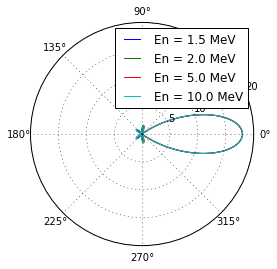

In [57]:
Energies = [1.5e6, 2e6, 5e6, 10e6] #eV
plt.subplot(111, polar=True)

for En in Energies:
    #I'm assuming ENDF uses lab frame energies.
    pdist_idx = (np.abs(Li7_pn_pdist['energy']-En)).argmin()
    #pdist_actualEn = Li7_pn_pdist['energy'][pdist_idx] #eV
    print('idx = {0}'.format(pdist_idx))
    pdist_LegPoly = calc_legendre(Li7_pn_pdist['Al'][pdist_idx])

    theta_p = np.linspace(0., 2*constants.pi, 1000)
    mu_p = np.cos(theta_p)
    plt.plot(theta_p, pdist_LegPoly(mu_p), label='En = {0} MeV'.format(En/1e6))

plt.legend()


In [58]:
Li7_pn_pdist['Al'][141]

array([ 0.11265   ,  0.011377  ,  0.00073266, -0.016362  , -0.0022293 ,
        0.001424  ])

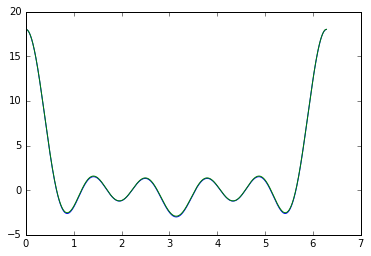

In [26]:
plt.subplot(111)#, polar='True')
plt.plot(theta_p, calc_legendre(Li7_pn_pdist['Al'][0])(mu_p))
plt.plot(theta_p, calc_legendre(Li7_pn_pdist['Al'][140])(mu_p))


In [265]:
LS['ElNaNeuts_Rate']*3600

array([  248.67982857,   869.51770831,  1990.69643636,  2780.07214304,
        3610.39381573,  2628.2639109 ,  3319.98083009,  2498.48403455])

In [188]:
NaRates_2p44*3600

array([  953.30046208,  3319.74684358,  5626.51904922,  7291.6523374 ,
        4116.21161381,  1253.17210277,  1279.47178751,  1004.80260491])

In [246]:
LS['RecoilEnergy_Na']/1000

array([   1.17946807,    6.76813975,   23.52029443,   89.66148412,
        222.56634786,  403.91639965,  491.78952282,  549.10490878])

In [199]:
print(ENa_2p44/1e3)
print(ENa_3/1e3)

[   0.24151033    1.38585837    4.81606439   18.35927192   45.57314816
   82.70676184  100.69984525  112.43586285]
[   0.43606518    2.50227212    8.69576856   33.1490542    82.2857663
  149.3333147   181.82118785  203.01145538]


In [203]:
LS['RecoilEnergy_I']/1000

array([   0.20152969,    1.15714443,    4.02897085,   15.47587546,
         39.02363766,   72.43032893,   89.19547362,  100.3493667 ])

In [90]:
NaRates_5p2/NaTotRate_5p2

array([ 0.81367748,  0.81400202,  0.81491269,  0.81773717,  0.82438265,
        0.83083024,  0.83719066,  0.84237757])

In [91]:
NaRates_3/NaTotRate_3

array([ 0.95020413,  0.95032591,  0.95068266,  0.95186101,  0.9544917 ,
        0.95692275,  0.95940501,  0.96133709])

In [92]:
NaRates_2p44/NaTotRate_2p44

array([ 0.98364147,  0.98369745,  0.98385405,  0.98433503,  0.98547139,
        0.98652866,  0.98752541,  0.98833821])

In [99]:
15/(NeutronSpeed_c(Target['nEnergy']/1e6)*30)

5.76583095425707

In [102]:
15/(NeutronSpeed_c(0.69)*30)

13.04649859532534

In [87]:
NaRates_2p44 = LS['ElNaNeuts_Rate']
NaTotRate_2p44 = LS['NeutronRateNa']
IRates_2p44 = LS['ElNaNeuts_Rate']
ENa_2p44 = LS['RecoilEnergy_Na']
ENa_2p44_Ulow = LS['nEnergy_spread_Na_low']
ENa_2p44_Uhigh = LS['nEnergy_spread_Na_high']
EI_2p44 = LS['RecoilEnergy_I']
EI_2p44_Ulow = LS['nEnergy_spread_I_low']
EI_2p44_Uhigh = LS['nEnergy_spread_I_high']

In [85]:
NaRates_3 = LS['ElNaNeuts_Rate']
NaTotRate_3 = LS['NeutronRateNa']
IRates_3 = LS['ElNaNeuts_Rate']
ENa_3 = LS['RecoilEnergy_Na']
ENa_3_Ulow = LS['nEnergy_spread_Na_low']
ENa_3_Uhigh = LS['nEnergy_spread_Na_high']
EI_3 = LS['RecoilEnergy_I']
EI_3_Ulow = LS['nEnergy_spread_I_low']
EI_3_Uhigh = LS['nEnergy_spread_I_high']

In [89]:
NaRates_5p2 = LS['ElNaNeuts_Rate']
NaTotRate_5p2 = LS['NeutronRateNa']
IRates_5p2 = LS['ElNaNeuts_Rate']
ENa_5p2 = LS['RecoilEnergy_Na']
ENa_5p2_Ulow = LS['nEnergy_spread_Na_low']
ENa_5p2_Uhigh = LS['nEnergy_spread_Na_high']
EI_5p2 = LS['RecoilEnergy_I']
EI_5p2_Ulow = LS['nEnergy_spread_I_low']
EI_5p2_Uhigh = LS['nEnergy_spread_I_high']

In [282]:
NaRates_Xu = LS['ElNaNeuts_Rate']

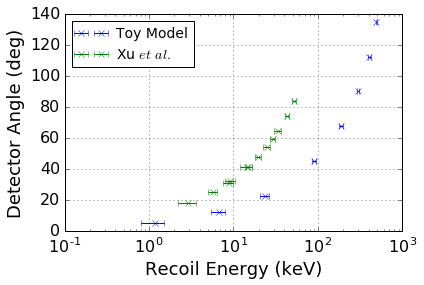

In [253]:
XuResults_recoil = np.array([29.0, 43.0, 15.0, 24.9, 5.7, 8.8, 19.4, 51.8, 9.1, 33.3, 2.9, 14.3])
XuResults_Urecoil = np.array([1.9, 2.2, 1.4, 2.4, 0.7, 1.2, 1.6, 2.6, 1.2, 2.8, 0.7, 2.4])
Xu_MeanAngle = np.array([59.1,74.2,41.3,54.4,24.9,31.1,47.9,84.0,32.2,64.6,18.2,41.1])
fig = plt.figure()
plt.errorbar(LS['RecoilEnergy_Na']/1e3, 
             LS['MeanAngle']*180/constants.pi, 
             xerr=[np.abs(LS['nEnergy_spread_Na_low'])/1e3, np.abs(LS['nEnergy_spread_Na_high'])/1e3],
             fmt='x')
plt.errorbar(XuResults_recoil, Xu_MeanAngle, xerr=XuResults_Urecoil, fmt='x')
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.ylabel('Detector Angle (deg)', fontsize=18)
plt.xlabel('Recoil Energy (keV)', fontsize=18)
plt.legend(['Toy Model', 'Xu $et$ $al.$'], loc='upper left', fontsize=14)
plt.grid(linestyle=':')
plt.tight_layout()
#plt.savefig('CompareXu_recoils.pdf')
#plt.ylim(0,1300)
plt.xscale('log')

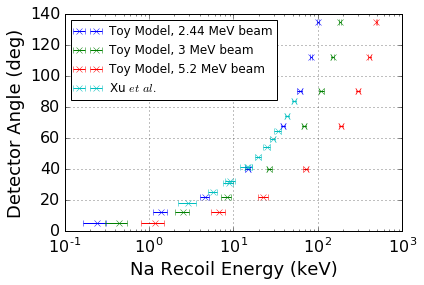

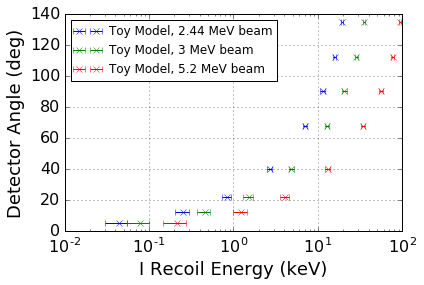

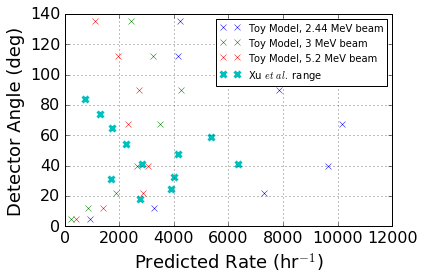

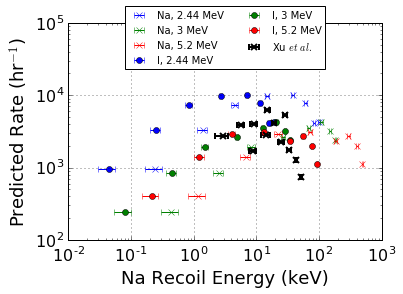

In [93]:
XuResults_recoil = np.array([29.0, 43.0, 15.0, 24.9, 5.7, 8.8, 19.4, 51.8, 9.1, 33.3, 2.9, 14.3])
XuResults_Urecoil = np.array([1.9, 2.2, 1.4, 2.4, 0.7, 1.2, 1.6, 2.6, 1.2, 2.8, 0.7, 2.4])
Xu_MeanAngle = np.array([59.1,74.2,41.3,54.4,24.9,31.1,47.9,84.0,32.2,64.6,18.2,41.1])
fig = plt.figure()
plt.errorbar(ENa_2p44/1e3, 
             LS['MeanAngle']*180/constants.pi, 
             xerr=[np.abs(ENa_2p44_Ulow/1e3), np.abs(ENa_2p44_Uhigh)/1e3],
             fmt='x')
plt.errorbar(ENa_3/1e3, 
             LS['MeanAngle']*180/constants.pi, 
             xerr=[np.abs(ENa_3_Ulow/1e3), np.abs(ENa_3_Uhigh)/1e3],
             fmt='x')
plt.errorbar(ENa_5p2/1e3, 
             LS['MeanAngle']*180/constants.pi, 
             xerr=[np.abs(ENa_5p2_Ulow/1e3), np.abs(ENa_5p2_Uhigh)/1e3],
             fmt='x')
plt.errorbar(XuResults_recoil, Xu_MeanAngle, xerr=XuResults_Urecoil, fmt='x')
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.ylabel('Detector Angle (deg)', fontsize=18)
plt.xlabel('Na Recoil Energy (keV)', fontsize=18)
plt.legend(['Toy Model, 2.44 MeV beam', 'Toy Model, 3 MeV beam', 'Toy Model, 5.2 MeV beam', 'Xu $et$ $al.$'], loc='upper left', fontsize=12)
plt.grid(linestyle=':')
plt.tight_layout()
#plt.savefig('CompareXu_recoils.pdf')
#plt.ylim(0,1300)
plt.xscale('log')

fig = plt.figure()
plt.errorbar(EI_2p44/1e3, 
             LS['MeanAngle']*180/constants.pi, 
             xerr=[np.abs(EI_2p44_Ulow/1e3), np.abs(EI_2p44_Uhigh)/1e3],
             fmt='x')
plt.errorbar(EI_3/1e3, 
             LS['MeanAngle']*180/constants.pi, 
             xerr=[np.abs(EI_3_Ulow/1e3), np.abs(EI_3_Uhigh)/1e3],
             fmt='x')
plt.errorbar(EI_5p2/1e3, 
             LS['MeanAngle']*180/constants.pi, 
             xerr=[np.abs(EI_5p2_Ulow/1e3), np.abs(EI_5p2_Uhigh)/1e3],
             fmt='x')
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.ylabel('Detector Angle (deg)', fontsize=18)
plt.xlabel('I Recoil Energy (keV)', fontsize=18)
plt.legend(['Toy Model, 2.44 MeV beam', 'Toy Model, 3 MeV beam', 'Toy Model, 5.2 MeV beam'], loc='upper left', fontsize=12)
plt.grid(linestyle=':')
plt.tight_layout()
#plt.savefig('CompareXu_recoils.pdf')
#plt.ylim(0,1300)
plt.xscale('log')


fig = plt.figure()
plt.plot(NaRates_2p44*3600, 
             LS['MeanAngle']*180/constants.pi,
             'x')
plt.plot(NaRates_3*3600, 
             LS['MeanAngle']*180/constants.pi, 
             'x')
plt.plot(NaRates_5p2*3600, 
             LS['MeanAngle']*180/constants.pi, 
             'x')
plt.plot(NaRates_Xu*3600, Xu_MeanAngle, 'x', markeredgewidth=3)
#plt.vlines([1000/26, 4000/20], 0, 140)
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.ylabel('Detector Angle (deg)', fontsize=18)
plt.xlabel('Predicted Rate (hr$^{-1}$)', fontsize=18)
plt.legend(['Toy Model, 2.44 MeV beam', 'Toy Model, 3 MeV beam', 'Toy Model, 5.2 MeV beam', 'Xu $et$ $al.$ range'], loc='upper right', fontsize=10)
plt.grid(linestyle=':')
plt.tight_layout()
#plt.savefig('CompareXu_recoils.pdf')
#plt.ylim(0,1300)
#plt.xscale('log')

fig = plt.figure()
plt.errorbar(ENa_2p44/1e3, 
             NaRates_2p44*3600, 
             xerr=[np.abs(ENa_2p44_Ulow/1e3), np.abs(ENa_2p44_Uhigh)/1e3],
             fmt='bx')
plt.errorbar(ENa_3/1e3, 
             NaRates_3*3600, 
             xerr=[np.abs(ENa_3_Ulow/1e3), np.abs(ENa_3_Uhigh)/1e3],
             fmt='gx')
plt.errorbar(ENa_5p2/1e3, 
             NaRates_5p2*3600, 
             xerr=[np.abs(ENa_5p2_Ulow/1e3), np.abs(ENa_5p2_Uhigh)/1e3],
             fmt='rx')
plt.errorbar(EI_2p44/1e3, 
             IRates_2p44*3600, 
             xerr=[np.abs(EI_2p44_Ulow/1e3), np.abs(EI_2p44_Uhigh)/1e3],
             fmt='bo')
plt.errorbar(EI_3/1e3, 
             IRates_3*3600, 
             xerr=[np.abs(EI_3_Ulow/1e3), np.abs(EI_3_Uhigh)/1e3],
             fmt='go')
plt.errorbar(EI_5p2/1e3, 
             IRates_5p2*3600, 
             xerr=[np.abs(EI_5p2_Ulow/1e3), np.abs(EI_5p2_Uhigh)/1e3],
             fmt='ro')
plt.errorbar(XuResults_recoil, NaRates_Xu*3600, xerr=XuResults_Urecoil, fmt='kx', markeredgewidth=2, linewidth=2)
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.ylabel('Predicted Rate (hr$^{-1}$)', fontsize=18)
plt.xlabel('Na Recoil Energy (keV)', fontsize=18)
plt.legend(['Na, 2.44 MeV', 'Na, 3 MeV', 'Na, 5.2 MeV', 'I, 2.44 MeV', 'I, 3 MeV', 'I, 5.2 MeV', 'Xu $et$ $al.$'], loc='upper center', fontsize=10, ncol=2, numpoints=1, bbox_to_anchor=(0.5, 1.1))
plt.grid(linestyle=':')
plt.tight_layout()
#plt.ylim(0,1300)
plt.xscale('log')
plt.yscale('log')
plt.savefig('CoincRatesVsEnergy.pdf')


In [338]:
LS['nTOF_I']

array([ 57.69997074,  38.47216546,  28.86581441,  28.90280905,
        19.32734201,  11.63173219,  11.6671668 ,  11.69729105])

In [297]:
LS['GammaTOF']

array([ 5.00346143,  3.33564095,  2.50173071,  2.50173071,  1.66782048,
        1.66782048,  1.00069229,  1.00069229])

In [66]:
(NaI['Distance']+LS['Distance'][0])*np.tan(LS['MeanAngle'][0]) #the off-axis distance of the most forward LS

array([ 11.37352626])

In [67]:
print(LS['Diameter'][0])

3.81


In [68]:
np.arctan(NaI['Dimension']/(2*NaI['Distance']))*180./np.pi

array([ 2.38594403])

In [69]:
(NaI['Distance']+LS['Distance'][0])*NaI['Dimension']/(2*NaI['Distance'][0]) #The spreading of the beam off axis

array([ 5.41666667])

10136.210820434411 mean protons per bunch
0.058651346746887566 mean neutrons per bunch produced by the target
72230.72259468913 neutrons per second produced by the target (period 1.384e-05 sec)
[ 4496.18738697] neutrons/sec incident on the NaI
[ 271.05266861] Na scatters/sec in the NaI
[ 422.2706416] I scatters/sec in the NaI
Rates of Na-scattered neutrons on the LS detectors
Per Second:
[  9.23983989   5.63901844  32.09864721]
Per Hour:
[  33263.42362009   20300.46640137  115555.12996287]
Rates (per second) of I-scattered neutrons on the LS detectors
Per Second:
[  5.73094622   5.29003119  24.86059706]
Per Hour:
[ 20631.4063978   19044.11229908  89498.14942077]


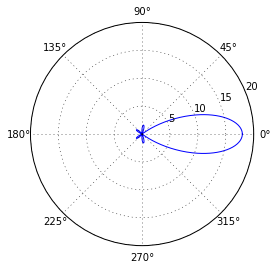

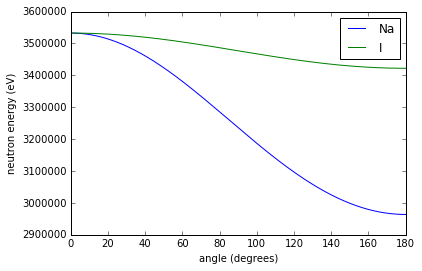

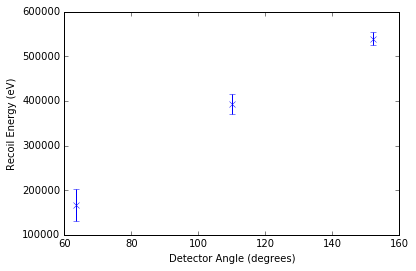

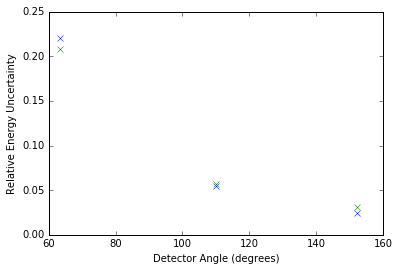

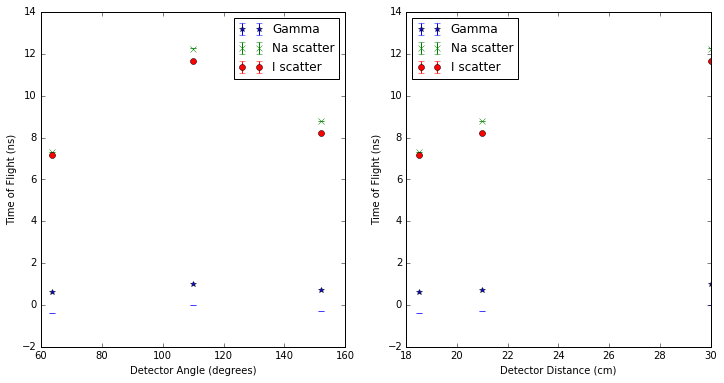

In [43]:
#plt.plot(LSthickness, TotCoincRate, 'x')
#Beam Test Feb 2018
#Beam properties:
Beam = {}
Beam['Current'] = 2e-9 #A, a value consistent with the Princeton group's claim of ~1e4 protons/bunch.
Beam['PulseWidth'] = 2e-9 #seconds
Beam['PulseFreq'] = 1/(812e-9) #Hz
Beam['ProtonsperBunch'] = Beam['Current']/(Beam['PulseFreq']* constants.elementary_charge)
print("{0} mean protons per bunch".format(Beam['ProtonsperBunch']))
Beam['SpotDiameter'] = 0.3 #cm
Beam['Energy'] = 5.2e6 #eV

##Target cross-sections
xsecs = {}
cm2perBarn = 1e-24
#I'm assuming ENDF uses lab frame energies.
Beam_xsec = Li7_pn.xs(Beam['Energy'])
Beam_xsec_cm2 = Beam_xsec*cm2perBarn
pdist_idx = (np.abs(Li7_pn_pdist['energy']-Beam['Energy'])).argmin()
pdist_actualEn = Li7_pn_pdist['energy'][pdist_idx] #eV
pdist_LegPoly = calc_legendre(Li7_pn_pdist['Al'][pdist_idx])

plt.subplot(111, polar=True)
theta_p = np.linspace(0., 2*constants.pi, 1000)
mu_p = np.cos(theta_p)
plt.plot(theta_p, pdist_LegPoly(mu_p))


#Target properties:
Target = {}
Target['Ecm'] = (1/(1+7))*Beam['Energy']
Target['Vcm'] = np.sqrt(2*Target['Ecm']/8)
Target['Composition'] = 'LiF'
Target['ArealDensity'] = 50e-6 #g/cm^2, number from Jack's report
Target['ArealDensity'] *= 10
Target['MolarMass'] = 25.939 #g/mol
Target['Li7ArealDensity'] = 0.95*Target['ArealDensity']/Target['MolarMass'] #95% enriched, mol/cm^2 #*(0.95*7/(0.95*7 + 0.05*6 + 9))
Target['Li7ArealNumberDensity'] = (Target['Li7ArealDensity']) * constants.Avogadro #atoms/cm^2
Target['Density'] = 2.64 #g/cm^3
Target['Li7Density'] = 0.95*Target['Density']/Target['MolarMass'] #mol/cm^3 #*(0.95*7/(0.95*7 + 0.05*6 + 9)) #g/cm^3
Target['Li7NumberDensity'] = (Target['Li7Density']) * constants.Avogadro #atoms/cm^3
Target['nProductionQvalue'] = Li7_pn.Q_reaction #eV
Target['nEnergy_CM'] = 7/8*(Beam['Energy'] - Target['Ecm'] + Target['nProductionQvalue']) #eV
Target['nVelocity_CM'] = np.sqrt(2*Target['nEnergy_CM']/1)
Target['nVelocity_Lab'] = Target['nVelocity_CM'] + Target['Vcm']
Target['nEnergy'] = 0.5*1*(Target['nVelocity_Lab']**2)
Target['Thickness'] = Target['Li7ArealNumberDensity']/Target['Li7NumberDensity'] #cm

#Reaction Rate:
Target['NeutronsPerBunch'] = Beam['ProtonsperBunch']*Target['Li7ArealNumberDensity']*Beam_xsec_cm2
print("{0} mean neutrons per bunch produced by the target".format(Target['NeutronsPerBunch']))
Target['NeutronRate'] = Target['NeutronsPerBunch']*Beam['PulseFreq']
print("{0} neutrons per second produced by the target (period {1:.3e} sec)".format(Target['NeutronRate'], 1/Target['NeutronRate']))

##Detector properties:
#NaI(Tl):
NaI = {}
NaI['DecayTime'] = 250 #ns
NaI['Dimension'] = 2*2.5 #cm, assume cube
NaI['LightYield'] = 4e4 #ph/MeV
NaI['PhotoelectronYield'] = 18200#*(40/25) #+/- 100 PE/MeV, modified for UBA photocathode
NaI['Distance'] = np.array([23.5]) #cm, configurations 1 and 2.
NaI['SpreadAngle'] = np.arctan(NaI['Dimension']/(2*(NaI['Distance'] + NaI['Dimension'])))
NaI['Density'] = 3.67 #g/cm3
NaI['MolarMass'] = 149.89 #g/mol
NaI['AtomDensity'] = (NaI['Density']/NaI['MolarMass'])*constants.Avogadro # atoms/cm^3
NaI['NaDensity'] = 0.5*NaI['AtomDensity'] # Na/cm^3
NaI['IDensity'] = 0.5*NaI['AtomDensity'] # I/cm^3

#Optionally just use 1/R^2 and neglect the extent of the NaI crystal.
use_1onR2_pn = False
#Alternatively, assume all neutrons are forward. This overrides use_1onR2.
assume_allForward_pn = False
#Set both of the above to false to do a more proper analysis.
if use_1onR2_pn or assume_allForward_pn:
    if not assume_allForward_pn:
        NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']/(NaI['Distance']**2)
    else:
        NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']    
else:
    #The problem is symmetric, so I can just work from 0-pi and use half the angle subtended by the NaI
    #at the target (defined by 'SpreadAngle' above). 
    #I'm using the back of the NaI as an approximation, though it doesn't make much difference if the size
    #of the NaI << distance to target.
    #integrand = lambda x: 0.5*pdist_LegPoly(np.cos(x))**2##Why was this squared?
    integrand = lambda x: 0.5*pdist_LegPoly(np.cos(x))*np.sin(x)
    TotalIntegral = integrate.quad(integrand, 0, constants.pi)[0]
    NaIIntegral = np.array([integrate.quad(integrand, 0, ang)[0] for ang in NaI['SpreadAngle']])
    NaI['FractionIncident'] = NaIIntegral/TotalIntegral
    NaI['NeutronsPerBunch'] = Target['NeutronsPerBunch']*NaI['FractionIncident'] #This is the number of neutrons incident per bunch

NaI['NeutronRate'] = NaI['NeutronsPerBunch']*Beam['PulseFreq'] #This is the rate of neutrons incident.

print("{0} neutrons/sec incident on the NaI".format(NaI["NeutronRate"]))

#Need to include calculation of Na (and I) scatter cross-section.
Neut_xsec_Naelastic = Na_elastic.xs(Target['nEnergy'])
Neut_xsec_Naelastic_cm2 = Neut_xsec_Naelastic*cm2perBarn
Neut_xsec_Ielastic = I_elastic.xs(Target['nEnergy'])
Neut_xsec_Ielastic_cm2 = Neut_xsec_Ielastic*cm2perBarn

NaI['NaScatter_perBunch'] = NaI['NeutronsPerBunch']*(1-np.exp(-(NaI['NaDensity']*NaI['Dimension'])*Neut_xsec_Naelastic_cm2))#(NaI['NaDensity']*NaI['Dimension'])*Neut_xsec_Naelastic_cm2 #Scatters/Bunch
NaI['NaScatter_Rate'] = NaI['NaScatter_perBunch']*Beam['PulseFreq']
NaI['IScatter_perBunch'] = NaI['NeutronsPerBunch']*(1-np.exp(-(NaI['IDensity']*NaI['Dimension'])*Neut_xsec_Ielastic_cm2))#(NaI['IDensity']*NaI['Dimension'])*Neut_xsec_Ielastic_cm2 #Scatters/Bunch
NaI['IScatter_Rate'] = NaI['IScatter_perBunch']*Beam['PulseFreq']
NaI['nTOF'] = NaI['Distance']/(NeutronSpeed_c(Target['nEnergy']/1e6)*constants.c*1e-7) #ns

print("{0} Na scatters/sec in the NaI".format(NaI["NaScatter_Rate"]))
print("{0} I scatters/sec in the NaI".format(NaI["IScatter_Rate"]))

#Work out scattering angle-energy distributions:
xsecs['m_neutron'] = constants.neutron_mass/constants.m_u #u
xsecs['m_p'] = constants.proton_mass/constants.m_u #u
xsecs['m_Na'] = 22.98976928196 #u 
xsecs['m_I']= 126.904471853 #u
xsecs['theta_cm'] = np.linspace(0, np.pi-0.001, 1000)
ElasticNa = {}
ElasticNa['energies'] = OutgoingEnergy(xsecs['theta_cm'], xsecs['m_neutron'], xsecs['m_Na'], Target['nEnergy'])
ElasticNa['angles'] = GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], ElasticNa['energies'])
ElasticI = {}
ElasticI['energies'] = OutgoingEnergy(xsecs['theta_cm'], xsecs['m_neutron'], xsecs['m_I'], Target['nEnergy'])
ElasticI['angles'] = GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], ElasticI['energies'])
xsecs['ElasticNa'] = ElasticNa
xsecs['ElasticI'] = ElasticI
fig = plt.figure()
#plt.plot(xsecs['theta_cm']*360/(2*constants.pi), xsecs['ElasticNa']['energies'], label='Na_COM')
#plt.plot(xsecs['theta_cm']*360/(2*constants.pi), xsecs['ElasticI']['energies'], label='I_COM')
plt.plot(xsecs['ElasticNa']['angles']*360/(2*constants.pi), 
         xsecs['ElasticNa']['energies'], label='Na')
plt.plot(xsecs['ElasticI']['angles']*360/(2*constants.pi), 
         xsecs['ElasticI']['energies'], label='I')
plt.legend()
plt.xlabel('angle (degrees)')
plt.ylabel('neutron energy (eV)')

Nascatter_idx = (np.abs(Na_elastic.angular_distribution.energy-Target['nEnergy'])).argmin()
Nascatter_actualEn = Na_elastic.angular_distribution.energy[Nascatter_idx] #eV
Iscatter_idx = (np.abs(I_elastic.angular_distribution.energy-Target['nEnergy'])).argmin()
Iscatter_actualEn = I_elastic.angular_distribution.energy[Iscatter_idx] #eV

#LS detector:
LS = {}
LS['Composition'] = 'EJ-301'
LS['Diameter'] = np.array([2.54*2]*3) #cm
LS['Length'] = np.array([2.54*2]*3) #cm
LS['Distance'] = np.array([30,21,18.5])
LS['NumDetectors'] = int(len(LS['Distance']))
LS['LightYield'] = 1e4 #ph/MeV
LS['PhotoelectronYield'] = -1 #Not mentioned in the paper
#LS['MeanAngle'] = np.array([24.9,31.1,41.3,47.9,54.4,59.1,74.2,84.0])*constants.pi/180 #radians
LS['MeanAngle'] = np.array([110,(180-27.9),63.5])*constants.pi/180 #radians
LS['SpreadAngle'] = np.arctan(LS['Diameter']/(2*LS['Distance'])) #Half the angle subtended by the LS detectors at the NaI.
use_1onR2_es=False
if use_1onR2_es:
    if len(NaI['NeutronsPerBunch'])==1:
        LS['NeutronsPerBunchNa'] = 0.5*NaI['NeutronsPerBunch']/(LS['Distance']**2)
        LS['NeutronsPerBunchI'] = 0.5*NaI['NeutronsPerBunch']/(LS['Distance']**2)
    else:
        LS['NeutronsPerBunchNa'] = 0.5*np.array(list(NaI['NeutronsPerBunch'])*LS['NumDetectors'])/(LS['Distance']**2)
        LS['NeutronsPerBunchI'] = 0.5*np.array(list(NaI['NeutronsPerBunch'])*LS['NumDetectors'])/(LS['Distance']**2)
else:
    #The problem is symmetric, so I can just work from 0-pi and use half the angle subtended by the LS
    #at the target (defined by 'SpreadAngle' above).
    integrandNa = lambda x: 0.5*Na_elastic.angular_distribution.probability[Nascatter_idx](np.cos(x))*np.sin(x)#**2
    integrandI = lambda x: 0.5*I_elastic.angular_distribution.probability[Iscatter_idx](np.cos(x))*np.sin(x)#**2
    TotalIntegralNa = integrate.quad(integrandNa, 0, constants.pi)[0]
    TotalIntegralI = integrate.quad(integrandNa, 0, constants.pi)[0]
    LSIntegralNa = np.array([integrate.quad(integrandNa, LS['MeanAngle'][i]-ang, LS['MeanAngle'][i]+ang)[0] 
                             for i, ang in enumerate(LS['SpreadAngle'])])
    LSIntegralI = np.array([integrate.quad(integrandI, LS['MeanAngle'][i]-ang, LS['MeanAngle'][i]+ang)[0] 
                             for i, ang in enumerate(LS['SpreadAngle'])])
    LS['FractionIncidentNa'] = LSIntegralNa/TotalIntegralNa #of the ones that get scattered
    LS['FractionIncidentI'] = LSIntegralI/TotalIntegralI #of the ones that get scattered
    #Multiply the NaI scatter per bunch (into 4pi) by the fraction incident on the LS.
    LS['NeutronsPerBunchNa'] = np.array(list(NaI['NaScatter_perBunch'])*LS['NumDetectors'])*LS['FractionIncidentNa']
    LS['NeutronsPerBunchI'] = np.array(list(NaI['IScatter_perBunch'])*LS['NumDetectors'])*LS['FractionIncidentI']
    
LS['NeutronRateNa'] = LS['NeutronsPerBunchNa']*Beam['PulseFreq']
LS['NeutronRateI'] = LS['NeutronsPerBunchI']*Beam['PulseFreq']

print("Rates of Na-scattered neutrons on the LS detectors\n\
Per Second:\n{0}\nPer Hour:\n{1}".format(LS["NeutronRateNa"], LS["NeutronRateNa"]*3600))
print("Rates (per second) of I-scattered neutrons on the LS detectors\n\
Per Second:\n{0}\nPer Hour:\n{1}".format(LS["NeutronRateI"], LS["NeutronRateI"]*3600))

LS['nEnergy_Na'] = np.interp(LS['MeanAngle'], GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                                         xsecs['ElasticNa']['energies']),
                             xsecs['ElasticNa']['energies'])
LS['nEnergy_I'] = np.interp(LS['MeanAngle'], GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                                         xsecs['ElasticI']['energies']),
                             xsecs['ElasticI']['energies'])
LS['RecoilEnergy_Na'] = Target['nEnergy'] - LS['nEnergy_Na']
LS['RecoilEnergy_I'] = Target['nEnergy'] - LS['nEnergy_I']
LS['nEnergy_spread_Na_low'] = np.interp((LS['MeanAngle']+LS['SpreadAngle']), 
                                          GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                      xsecs['ElasticNa']['energies']), 
                                         xsecs['ElasticNa']['energies']) - LS['nEnergy_Na']
LS['nEnergy_spread_Na_high'] = np.interp((LS['MeanAngle']-LS['SpreadAngle']), 
                                         GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_Na'], 
                                                      xsecs['ElasticNa']['energies']), 
                                         xsecs['ElasticNa']['energies']) - LS['nEnergy_Na']
LS['nEnergy_spread_I_low'] = np.interp((LS['MeanAngle']+LS['SpreadAngle']), 
                                          GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                      xsecs['ElasticI']['energies']), 
                                         xsecs['ElasticI']['energies']) - LS['nEnergy_I']
LS['nEnergy_spread_I_high'] = np.interp((LS['MeanAngle']-LS['SpreadAngle']), 
                                        
                                         GetLabAngle(Target['nEnergy'], xsecs['m_neutron'], xsecs['m_I'], 
                                                      xsecs['ElasticI']['energies']), 
                                         xsecs['ElasticI']['energies']) - LS['nEnergy_I']

LS['nTOF_Na'] = LS['Distance']/(NeutronSpeed_c(LS['nEnergy_Na']/1e6)*constants.c*1e-7) #ns
LS['nTOF_I'] = LS['Distance']/(NeutronSpeed_c(LS['nEnergy_I']/1e6)*constants.c*1e-7) #ns
LS['nTOF_spread_Na_low'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_Na'] + LS['nEnergy_spread_Na_low'])/1e6)
                                           *constants.c*1e-7) #ns
LS['nTOF_spread_Na_high'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_Na'] + LS['nEnergy_spread_Na_high'])/1e6)
                                            *constants.c*1e-7) #ns
LS['nTOF_spread_I_low'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_I'] + LS['nEnergy_spread_I_low'])/1e6)
                                          *constants.c*1e-7) #ns
LS['nTOF_spread_I_high'] = LS['Distance']/(NeutronSpeed_c((LS['nEnergy_I'] + LS['nEnergy_spread_I_high'])/1e6)
                                           *constants.c*1e-7) #ns

LS['GammaTOF'] = LS['Distance']/(constants.c*1e-7)

LS['Hdensity'] = 5.43e22 #From EJ-309 datahsheet
LS_xsec_Helastic_Na = H_elastic.xs(LS['nEnergy_Na'])
LS_xsec_Helastic_Na_cm2 = LS_xsec_Helastic_Na*cm2perBarn
LS_xsec_Helastic_I = H_elastic.xs(LS['nEnergy_I'])
LS_xsec_Helastic_I_cm2 = LS_xsec_Helastic_I*cm2perBarn

LS['ElNaNeuts_perBunch'] = LS['NeutronsPerBunchNa']*(1-np.exp(-(LS['Hdensity']*LS['Length'])*LS_xsec_Helastic_Na_cm2)) #Scatters/Bunch
LS['ElNaNeuts_Rate'] = LS['ElNaNeuts_perBunch']*Beam['PulseFreq']
LS['ElINeuts_perBunch'] = LS['NeutronsPerBunchI']*(1-np.exp(-(LS['Hdensity']*LS['Length'])*LS_xsec_Helastic_I_cm2)) #Scatters/Bunch
LS['ElINeuts_Rate'] = LS['ElINeuts_perBunch']*Beam['PulseFreq']

fig = plt.figure()
plt.errorbar(LS['MeanAngle']*180/constants.pi, 
             LS['RecoilEnergy_Na'], 
             yerr=[np.abs(LS['nEnergy_spread_Na_low']), np.abs(LS['nEnergy_spread_Na_high'])],
             fmt='x')
#print("Relative Error: {0}".format((LS['nEnergy_spread_Na_low']/LS['RecoilEnergy_Na'], 
#                                    LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na'])))

plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Recoil Energy (eV)')

fig = plt.figure()
plt.plot(LS['MeanAngle']*180/constants.pi, np.abs(LS['nEnergy_spread_Na_low']/LS['RecoilEnergy_Na']), 'x')
plt.plot(LS['MeanAngle']*180/constants.pi, np.abs(LS['nEnergy_spread_Na_high']/LS['RecoilEnergy_Na']), 'x')
plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Relative Energy Uncertainty')

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['GammaTOF'], fmt='*', yerr=[[1]*len(LS['GammaTOF']),[-1]*len(LS['GammaTOF'])],
             label='Gamma')
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['nTOF_Na'], yerr=[LS['nTOF_spread_Na_high']-LS['nTOF_Na'],
                                                                    LS['nTOF_spread_Na_low']-LS['nTOF_Na']], 
             fmt='x', label='Na scatter')
plt.errorbar(LS['MeanAngle']*180/constants.pi, LS['nTOF_I'], yerr=[LS['nTOF_spread_I_high']-LS['nTOF_I'], 
                                                                   LS['nTOF_spread_I_low']-LS['nTOF_I']], 
             fmt='o', label='I scatter')
plt.xlabel('Detector Angle (degrees)')
plt.ylabel('Time of Flight (ns)')
plt.legend()

plt.subplot(122)
plt.errorbar(LS['Distance'], LS['GammaTOF'], fmt='*', yerr=[[1]*len(LS['GammaTOF']),[-1]*len(LS['GammaTOF'])],
             label='Gamma')
plt.errorbar(LS['Distance'], LS['nTOF_Na'], yerr=[LS['nTOF_spread_Na_high']-LS['nTOF_Na'],
                                                                    LS['nTOF_spread_Na_low']-LS['nTOF_Na']], 
             fmt='x', label='Na scatter')
plt.errorbar(LS['Distance'], LS['nTOF_I'], yerr=[LS['nTOF_spread_I_high']-LS['nTOF_I'], 
                                                                   LS['nTOF_spread_I_low']-LS['nTOF_I']], 
             fmt='o', label='I scatter')
plt.xlabel('Detector Distance (cm)')
plt.ylabel('Time of Flight (ns)')
plt.legend(loc='upper left')

In [87]:
Target

{'ArealDensity': 0.0005,
 'Composition': 'LiF',
 'Density': 2.64,
 'Ecm': 650000.0,
 'Li7ArealDensity': 1.831219399360037e-05,
 'Li7ArealNumberDensity': 1.1027861163017079e+19,
 'Li7Density': 0.09668838428620996,
 'Li7NumberDensity': 5.822710694073018e+22,
 'MolarMass': 25.939,
 'NeutronRate': 72230.722594689127,
 'NeutronsPerBunch': 0.058651346746887566,
 'Thickness': 0.00018939393939393937,
 'Vcm': 403.11288741492746,
 'nEnergy': 3532752.5920089283,
 'nEnergy_CM': 2542487.5,
 'nProductionQvalue': -1644300.0,
 'nVelocity_CM': 2254.9889134982459,
 'nVelocity_Lab': 2658.1018009131735}

In [86]:
NaI

{'AtomDensity': 1.4744984285269199e+22,
 'DecayTime': 250,
 'Density': 3.67,
 'Dimension': 2.5,
 'Distance': array([ 23.5]),
 'FractionIncident': array([ 0.0189944]),
 'IDensity': 7.372492142634599e+21,
 'IScatter_Rate': array([ 66.01461586]),
 'IScatter_perBunch': array([  5.36038681e-05]),
 'LightYield': 40000.0,
 'MolarMass': 149.89,
 'NaDensity': 7.372492142634599e+21,
 'NaScatter_Rate': array([ 41.99768242]),
 'NaScatter_perBunch': array([  3.41021181e-05]),
 'NeutronRate': array([ 1371.97925435]),
 'NeutronsPerBunch': array([ 0.00111405]),
 'PhotoelectronYield': 18200,
 'SpreadAngle': array([ 0.04803993]),
 'nTOF': array([ 9.03938867])}

In [44]:
LS

{'Composition': 'EJ-301',
 'Diameter': array([ 5.08,  5.08,  5.08]),
 'Distance': array([ 30. ,  21. ,  18.5]),
 'ElINeuts_Rate': array([  2.51193555,   2.32797159,  10.83219472]),
 'ElINeuts_perBunch': array([  2.03969166e-06,   1.89031293e-06,   8.79574212e-06]),
 'ElNaNeuts_Rate': array([  4.23611859,   2.64056449,  14.25112593]),
 'ElNaNeuts_perBunch': array([  3.43972830e-06,   2.14413836e-06,   1.15719143e-05]),
 'FractionIncidentI': array([ 0.01357174,  0.01252758,  0.05887361]),
 'FractionIncidentNa': array([ 0.03408873,  0.02080414,  0.11842218]),
 'GammaTOF': array([ 1.00069229,  0.7004846 ,  0.61709358]),
 'Hdensity': 5.43e+22,
 'Length': array([ 5.08,  5.08,  5.08]),
 'LightYield': 10000.0,
 'MeanAngle': array([ 1.91986218,  2.65464579,  1.10828408]),
 'NeutronRateI': array([  5.73094622,   5.29003119,  24.86059706]),
 'NeutronRateNa': array([  9.23983989,   5.63901844,  32.09864721]),
 'NeutronsPerBunchI': array([  4.65352833e-06,   4.29550533e-06,   2.01868048e-05]),
 'Ne

In [48]:
LS['RecoilEnergy_Na']/1000

array([ 392.72295063,  538.58243531,  167.64278959])

In [49]:
(LS['RecoilEnergy_Na']+LS['nEnergy_spread_Na_high'])/1000

array([ 415.00055252,  555.07461936,  202.56806131])

In [50]:
(LS['RecoilEnergy_Na']+LS['nEnergy_spread_Na_low'])/1000

array([ 371.27130273,  525.52654462,  130.64748186])

In [55]:
LS['MeanAngle']*180/np.pi

array([ 110. ,  152.1,   63.5])

In [54]:
((LS['nEnergy_spread_Na_low'])/1000, LS['nEnergy_spread_Na_high']/1000)

(array([-21.4516479 , -13.05589068, -36.99530773]),
 array([ 22.27760189,  16.49218405,  34.92527172]))